
## Regex vs NLP vs CyNER vs LLMs

Tim Angevare - t.p.angevare@student.utwente.nl

This notebook evaluates four approaches for extracting Indicators of Compromise (IoCs) from The Cipher Trail cybercrime investigation document:
1. **Regex-based extraction** - Pattern matching
2. **NLP-based extraction** - spaCy with custom rules
3. **Gliner-PII extraction** - 
4. **LLM-based extraction** - Multiple open-source LLMs with prompt engineering

**Target IoC Types:**
- Email addresses
- IP addresses (v4/v6)
- Financial addresses (IBAN, BTC, etc)
- Person names
- Locations
- Domains
- Usernames

Methodology based on cake recipe
https://github.com/jjsantanna/cake_recipe_for_students/blob/master/cake_of_llm.md

## Section 1: Setup & Environment

In [66]:
import os
from datetime import datetime
import json
from pathlib import Path
import numpy as np
print(f"NumPy version: {np.__version__}")
import pandas as pd
import re
from difflib import SequenceMatcher
from collections import defaultdict

#for LLM extraction
import ollama

# For NLP extraction
import spacy

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

NumPy version: 1.26.4


In [67]:
import sys
# This tricks Python into thinking TensorFlow is already 'loaded' as nothing
sys.modules["tensorflow"] = None 

from gliner import GLiNER

## Section 2: Dataset Preparation
### 2.1 Load The Cipher Trail Document

In [68]:
documents_path = Path('Cipher mails')

print(f"documents: {len(list(documents_path.glob('*.json')))}")

documents: 13


In [69]:
def parse_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['entities'], data['text']

dataset = {
    "gt_entities" : [],
    "regex_entities" : [],
    "regex_metrics" : [],
    "regex_time" : [],
    "nlp_entities" : [],
    "cyner_entities" : [],
    "text" : [],
    "filenames" : []
}

for file in documents_path.glob('*.json'):
    entities, text = parse_json_file(file)
    dataset['gt_entities'].append(entities)
    dataset['text'].append(text)
    dataset['filenames'].append(file.name)

print(f"Loaded {len(dataset['filenames'])} documents.")
types = []

for files in dataset['gt_entities']:
    for entity in files:
        if entity['type'] not in types:
            types.append(entity['type'])

print(f"Entity types in ground truth: {types}")

Loaded 13 documents.
Entity types in ground truth: ['PERSON', 'EMAIL', 'LOCATION', 'BTC', 'URL', 'PHONE', 'IP', 'TOX']


## Section 3: Evaluation Metrics

These functions calculate precision, recall, and F1-score for entity extraction.

In [70]:
def compute_overlap(span1, span2):
    """
    Compute Intersection over Union (IoU) for two spans.
    span: (start, end) tuple
    """
    start1, end1 = span1
    start2, end2 = span2
    
    # Compute intersection
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)
    
    if intersection_start >= intersection_end:
        return 0.0
    
    intersection = intersection_end - intersection_start
    
    # Compute union
    union = (end1 - start1) + (end2 - start2) - intersection
    
    return intersection / union if union > 0 else 0.0


def entity_matches(pred_entity, gt_entity, match_type='partial'):
    """
    Check if predicted entity matches ground truth entity.
    
    Args:
        pred_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        gt_entity: dict with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' (exact span match) or 'partial' (IoU > 0.5)
    
    Returns:
        float: 1.0 for exact match, 0.5 for partial match, 0.0 for no match
    """
    # Type must match
    if pred_entity['type'].lower() != gt_entity['type'].lower():
        return 0.0
    
    # If positions are not available, use text matching
    if pred_entity.get('start_pos', -1) == -1 or gt_entity.get('start_pos', -1) == -1:
        if pred_entity['text'].lower() == gt_entity['text'].lower():
            return 1.0
        return 0.0
    
    pred_span = (pred_entity['start_pos'], pred_entity['end_pos'])
    gt_span = (gt_entity['start_pos'], gt_entity['end_pos'])
    
    if match_type == 'exact':
        # Exact span match
        if pred_span == gt_span:
            return 1.0
        return 0.0
    
    elif match_type == 'partial':
        # Partial match using IoU
        iou = compute_overlap(pred_span, gt_span)
        if iou >= 0.5:
            return 0.5  # Partial credit
        return 0.0
    
    return 0.0


def calculate_ner_metrics(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics: Precision, Recall, F1-score.
    
    Args:
        predicted_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        ground_truth_entities: list of dicts with keys 'text', 'type', 'start_pos', 'end_pos'
        match_type: 'exact' or 'partial'
    
    Returns:
        dict with 'precision', 'recall', 'f1', 'tp', 'fp', 'fn'
    """
    # Handle edge case: both empty lists = perfect score (correctly predicted no entities)
    if len(predicted_entities) == 0 and len(ground_truth_entities) == 0:
        return {
            'precision': 1.0,
            'recall': 1.0,
            'f1': 1.0,
            'tp': 0.0,
            'fp': 0,
            'fn': 0,
            'fp_entities': [],
            'fn_entities': []
        }
    
    TP = 0.0
    FP_entities = []
    
    # Track which GT entities have been matched
    matched_gt = set()
    
    # Check each predicted entity
    for pred_ent in predicted_entities:
        best_match_score = 0.0
        best_match_idx = -1
        
        for idx, gt_ent in enumerate(ground_truth_entities):
            if idx in matched_gt:
                continue
            
            score = entity_matches(pred_ent, gt_ent, match_type)
            if score > best_match_score:
                best_match_score = score
                best_match_idx = idx
        
        if best_match_score > 0:
            TP += best_match_score
            matched_gt.add(best_match_idx)
        else:
            FP_entities.append(pred_ent)
    
    # Count unmatched ground truth entities as false negatives
    FN_entities = [gt_entity for i, gt_entity in enumerate(ground_truth_entities) if i not in matched_gt]
    
    FP = len(FP_entities)
    FN = len(FN_entities)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': TP,
        'fp': FP,
        'fn': FN,
        'fp_entities' : FP_entities,
        'fn_entities' : FN_entities
    }


def calculate_ner_metrics_by_type(predicted_entities, ground_truth_entities, match_type='partial'):
    """
    Calculate NER metrics for each entity type separately.
    
    Returns:
        dict: {entity_type: {precision, recall, f1}}
    """
    # Get all unique entity types
    all_types = set()
    for ent in predicted_entities + ground_truth_entities:
        all_types.add(ent['type'].lower())
    
    results = {}
    for ent_type in all_types:
        pred_type = [e for e in predicted_entities if e['type'].lower() == ent_type]
        gt_type = [e for e in ground_truth_entities if e['type'].lower() == ent_type]
        
        metrics = calculate_ner_metrics(pred_type, gt_type, match_type)
        results[ent_type] = metrics
    
    return results

## Section 4: Method 1 - Regex Extraction
### 4.1 Define Regex Patterns

Regex is great for standards like email adresses and BTC wallets but cannot be used for names and locations

In [71]:
# Comprehensive regex patterns for IoC extraction
#second ip is ipv6

ioc_patterns = {
    'EMAIL': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
    'IP': r'\b(?:(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(?:25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\b|(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|::(?:[0-9a-fA-F]{1,4}:){0,5}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}',
    'IP' : r'\b(?:\d{1,3}\.){3}\d{1,3}\b', #defanged with [.]
    'PHONE': r'\+(\d{1,3})[\s.-]?\(?\d{1,4}\)?[\s.-]?\d{1,4}[\s.-]?\d{1,9}',
    'URL': r'(?:https?|ftp|sftp)://[a-zA-Z0-9][a-zA-Z0-9.-]*\.[a-zA-Z]{2,}(?::\d+)?(?:/[^\s.]*)?(?:\.(?!\s|$))?',
    'TOX': r'\b[0-9a-fA-F]{76}\b',
    'IBAN': r'\b[A-Z]{2}\d{2}[A-Z0-9]{4,30}\b',
    'BTC': r'\b(?:bc1[a-z0-9]{39,59}|[13][a-zA-HJ-NP-Z0-9]{25,33})\b',
    'ETH': r'\b0x[a-fA-F0-9]{40}\b',
    'XMR': r'\b4[0-9AB][1-9A-HJ-NP-Za-km-z]{93}\b',
    'LTC': r'\b[LM3][a-km-zA-HJ-NP-Z1-9]{26,33}\b'
}
print("=== Regex Patterns ===")
for ioc_type, pattern in ioc_patterns.items():
    print(f"{ioc_type}: {pattern}")

=== Regex Patterns ===
EMAIL: \b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b
IP: \b(?:\d{1,3}\.){3}\d{1,3}\b
PHONE: \+(\d{1,3})[\s.-]?\(?\d{1,4}\)?[\s.-]?\d{1,4}[\s.-]?\d{1,9}
URL: (?:https?|ftp|sftp)://[a-zA-Z0-9][a-zA-Z0-9.-]*\.[a-zA-Z]{2,}(?::\d+)?(?:/[^\s.]*)?(?:\.(?!\s|$))?
TOX: \b[0-9a-fA-F]{76}\b
IBAN: \b[A-Z]{2}\d{2}[A-Z0-9]{4,30}\b
BTC: \b(?:bc1[a-z0-9]{39,59}|[13][a-zA-HJ-NP-Z0-9]{25,33})\b
ETH: \b0x[a-fA-F0-9]{40}\b
XMR: \b4[0-9AB][1-9A-HJ-NP-Za-km-z]{93}\b
LTC: \b[LM3][a-km-zA-HJ-NP-Z1-9]{26,33}\b


### 4.2 Extract IoCs with Regex

In [72]:
def extract_iocs_regex(text, patterns):
    """
    Extract IoCs from text using regex patterns.
    
    Args:
        text: source text
        patterns: dict of {ioc_type: regex_pattern}
    
    Returns:
        list of entity dicts with 'text', 'type', 'start_pos', 'end_pos'
    """
    
    entities = []
    
    for ioc_type, pattern in patterns.items():
        for match in re.finditer(pattern, text, re.IGNORECASE):
            entity = {
                'text': match.group(),
                'type': ioc_type,
                'start_pos': match.start(),
                'end_pos': match.end()
            }
            entities.append(entity)
    
    return entities

# Extract IoCs using regex

for text in dataset['text']:
    regex_start_time = datetime.now()
    entities = extract_iocs_regex(text, ioc_patterns)
    dataset['regex_entities'].append(entities)
    regex_elapsed_time = (datetime.now() - regex_start_time).total_seconds()
    dataset['regex_time'].append(regex_elapsed_time)
    print(f"=== Regex Extraction Results ===")
    print(f"Extracted {len(entities)} entities in {regex_elapsed_time:.4f} seconds")

=== Regex Extraction Results ===
Extracted 2 entities in 0.0002 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0004 seconds
=== Regex Extraction Results ===
Extracted 1 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0002 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0005 seconds
=== Regex Extraction Results ===
Extracted 1 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 2 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0004 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0008 seconds
=== Regex Extraction Results ===
Extracted 6 entities in 0.0004 seconds
=== Regex Extraction Results ===
Extracted 3 entities in 0.0003 seconds
=== Regex Extraction Results ===
Extracted 4 entities in 0.0002 seconds


### 4.3 Calculate Metrics

In [73]:
def calc_avg_ner_metrics(pred_entities):
    precision = []
    recall = []
    f1 = []
    TP = 0
    FP = 0
    FN = 0

    for idx in range(len(dataset['filenames'])):
        regex_metrics = calculate_ner_metrics(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        precision.append(regex_metrics['precision'])
        recall.append(regex_metrics['recall'])
        f1.append(regex_metrics['f1'])
        TP += regex_metrics['tp']
        FP += regex_metrics['fp']
        FN += regex_metrics['fn']
    avg_metrics = {
        'precision': np.mean(precision),
        'recall': np.mean(recall),
        'f1': np.mean(f1),
        'tp': TP,
        'fp': FP,
        'fn': FN
    }
    return avg_metrics

dataset['regex_metrics'] = calc_avg_ner_metrics(dataset['regex_entities'])


In [74]:

def calc_avg_ner_metrics_by_type(pred_entities):
    type_stats = defaultdict(lambda: defaultdict(list))

    for idx in range(len(dataset['filenames'])):
        regex_metrics_by_type = calculate_ner_metrics_by_type(
            pred_entities[idx],
            dataset['gt_entities'][idx],
            match_type='partial'
        )
        for entity_type, metrics in regex_metrics_by_type.items():
            for metric_name, value in metrics.items():
                type_stats[entity_type][metric_name].append(value)

    averages = {}
    for entity_type, metrics_lists in type_stats.items():
        averages[entity_type] = {}
        for metric_name, values in metrics_lists.items():
            if metric_name != 'fp_entities' and metric_name != 'fn_entities':
                averages[entity_type][metric_name] = sum(values) / len(values)
    return averages


In [75]:
dataset['regex_entities']

[[{'text': 'ahargrove92@pm.me',
   'type': 'EMAIL',
   'start_pos': 74,
   'end_pos': 91},
  {'text': 'm.grant512@tuta.io',
   'type': 'EMAIL',
   'start_pos': 96,
   'end_pos': 114}],
 [{'text': 'marcellus.grant@protonmail.com',
   'type': 'EMAIL',
   'start_pos': 233,
   'end_pos': 263},
  {'text': 'anna.h@techparadox.io',
   'type': 'EMAIL',
   'start_pos': 268,
   'end_pos': 289},
  {'text': 'm.grant512@tuta.io',
   'type': 'EMAIL',
   'start_pos': 751,
   'end_pos': 769}],
 [{'text': 'bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0h3p9a4f',
   'type': 'BTC',
   'start_pos': 371,
   'end_pos': 413}],
 [{'text': 'c.varga@journalisttruth.org',
   'type': 'EMAIL',
   'start_pos': 35,
   'end_pos': 62},
  {'text': 'cv.editor@riseup.net',
   'type': 'EMAIL',
   'start_pos': 63,
   'end_pos': 83}],
 [{'text': 'cv.editor@riseup.net',
   'type': 'EMAIL',
   'start_pos': 41,
   'end_pos': 61},
  {'text': 'bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq5kzm68d',
   'type': 'BTC',
   'start_pos': 179,
   'end_pos': 

In [76]:
dataset['regex_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['regex_entities'])
# Create a DataFrame for display
print(dataset['regex_type_metrics'])

df = pd.DataFrame(dataset['regex_type_metrics']).T
print(df)

{'email': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.6666666666666667, 'fp': 0.0, 'fn': 0.0}, 'person': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 3.3076923076923075}, 'location': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0.0, 'fp': 0.0, 'fn': 1.6}, 'btc': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.5, 'fp': 0.0, 'fn': 0.0}, 'tox': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.0, 'fp': 0.0, 'fn': 0.0}, 'url': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 1.6666666666666667, 'fp': 0.0, 'fn': 0.0}, 'ip': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'tp': 1.25, 'fp': 0.0, 'fn': 0.25}, 'phone': {'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'tp': 1.0, 'fp': 0.0, 'fn': 0.25}}
          precision  recall    f1        tp   fp        fn
email          1.00    1.00  1.00  1.666667  0.0  0.000000
person         0.00    0.00  0.00  0.000000  0.0  3.307692
location       0.00    0.00  0.00  0.000000  0.0  1.600000
btc       

## Section 5: Method 2 - NLP Extraction
### 5.1 Setup NLP Pipeline

Hypothesis is that NLP will be beter in extracting locations and names

In [77]:
# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model loaded: en_core_web_sm")
except:
    print("spaCy model not found. Installing...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model installed and loaded")

spaCy model loaded: en_core_web_sm


In [78]:
ruler = nlp.add_pipe("entity_ruler", before="ner")
patterns = [
    {"label": "EMAIL", "pattern": [{"LIKE_EMAIL": True}]},
    {"label": "URL", "pattern": [{"LIKE_URL": True}]}
]
ruler.add_patterns(patterns)

### 5.2 Extract Entities with NLP

In [79]:
entities = nlp('Hello my name is Tim and my email is t.p.angevare@student.utwente.nl. His iban is NL46RABO0304375722').ents
for ent in entities:
    print(ent.text, ent.label_)

Tim PERSON
t.p.angevare@student.utwente.nl EMAIL
NL46RABO0304375722 ORG


In [80]:
def extract_iocs_nlp(text, nlp_model):
    """
    Extract IoCs using NLP (spaCy) + hybrid regex approach.
    
    Args:
        text: source text
        nlp_model: spaCy model
        regex_patterns: dict of regex patterns for technical IoCs
    
    Returns:
        list of entity dicts
    """
    entities = []
    
    # Process text with spaCy
    doc = nlp_model(text)
    
    # Entity type mapping from spaCy to our IoC types
    spacy_to_ioc_mapping = {
        'PERSON': 'PERSON',
        'GPE': 'LOCATION',  # Geopolitical entity
        'LOC': 'LOCATION',
        'ORG': 'ORGANIZATION',
        'EMAIL' : 'EMAIL',
        'FINANCIAL_ACOUNT' : 'FINANCIAL_ACCOUNT',
        'IP' : 'IP',
        'PHONE' : 'PHONE',
        'URL' : 'URL'
    }
    
    # Extract named entities from spaCy
    for ent in doc.ents:
        if ent.label_ in spacy_to_ioc_mapping:
            entity = {
                'text': ent.text,
                'type': spacy_to_ioc_mapping[ent.label_],
                'start_pos': ent.start_char,
                'end_pos': ent.end_char
            }
            entities.append(entity)
    
    return entities

In [81]:
# Extract IoCs using NLP

dataset['nlp_entities'] = []
dataset['nlp_time'] = []

for text in dataset['text']:
    nlp_start_time = datetime.now()
    nlp_entities = extract_iocs_nlp(text, nlp)
    dataset['nlp_entities'].append(nlp_entities)
    nlp_elapsed_time = (datetime.now() - nlp_start_time).total_seconds()
    dataset['nlp_time'].append(nlp_elapsed_time)

    print(f"=== NLP Extraction Results ===")
    print(f"Extracted {len(nlp_entities)} entities in {nlp_elapsed_time:.4f} seconds")
    print(f"\nEntity type distribution:")
    nlp_type_counts = defaultdict(int)


=== NLP Extraction Results ===
Extracted 3 entities in 0.0162 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 9 entities in 0.0348 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 3 entities in 0.0213 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 6 entities in 0.0168 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 4 entities in 0.0227 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 8 entities in 0.0391 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 3 entities in 0.0234 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 7 entities in 0.0262 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 6 entities in 0.0287 seconds

Entity type distribution:
=== NLP Extraction Results ===
Extracted 4 entities in 0.0252 seconds

Entity type distribution:
=== NLP Extraction Results ===

### 5.3 Calculate NLP Metrics

In [82]:
dataset['nlp_metrics'] = calc_avg_ner_metrics(dataset['nlp_entities'])
print(dataset['nlp_metrics'])

{'precision': 0.6670024420024419, 'recall': 0.5423382173382174, 'f1': 0.5897234238863198, 'tp': 47.0, 'fp': 26, 'fn': 41}


In [83]:
dataset['nlp_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['nlp_entities'])
# Create a DataFrame for display
df_nlp = pd.DataFrame(dataset['nlp_type_metrics']).T
print(df_nlp)

              precision    recall        f1        tp        fp        fn
email          1.000000  1.000000  1.000000  1.666667  0.000000  0.000000
person         0.788462  0.497070  0.594705  1.538462  0.307692  1.769231
location       0.611111  0.666667  0.633333  1.166667  0.666667  0.166667
url            0.416667  0.500000  0.444444  0.833333  0.833333  0.000000
btc            0.000000  0.000000  0.000000  0.000000  0.000000  1.500000
organization   0.000000  0.000000  0.000000  0.000000  1.857143  0.000000
tox            0.000000  0.000000  0.000000  0.000000  0.000000  1.000000
ip             0.000000  0.000000  0.000000  0.000000  0.000000  1.500000
phone          0.000000  0.000000  0.000000  0.000000  0.000000  1.250000


### 5.4 Nvidia PII Extraction

Nvidia GLiNER-PII is a specialized NER model fine-tuned on cybersecurity data, designed to recognize:
- Indicators of Compromise (IPs, URLs, file hashes)
- Organization names

In [84]:
model = GLiNER.from_pretrained("nvidia/gliner-PII")

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [85]:
entity_labels = list(ioc_patterns.keys()) + ['PERSON', 'LOCATION']

In [86]:
pred_entities = model.predict_entities("The files arrived encrypted via a secure folder. Anna decrypted them with a shared key from their college days. Inside was a high-resolution scan of the painting and a text file labeled ciphertrail.txt. After several hours of sifting through the image metadata and running analysis tools, Anna discovered a steganographic message that revealed a partial Bitcoin address: bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0h3p9a4f. It didn't belong to Marcellus. She double-checked.",
                                 labels=entity_labels)
for ent in entities:
    print(ent)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tim
t.p.angevare@student.utwente.nl
NL46RABO0304375722


In [87]:
dataset['PII_entities'] = []
dataset['PII_time'] = []
# Extract IoCs using CyNER
for text in dataset['text']:
    PII_start_time = datetime.now()
    pred_entities = model.predict_entities(text, labels=entity_labels)
    PII_entities = []
    for entity in pred_entities:
        PII_entities.append(
            {
                'type' : entity['label'],
                'text' : entity['text'],
                'start_pos' : entity['start'],
                'end_pos' : entity['end']
            }
        )
        
    dataset['PII_entities'].append(PII_entities)
    PII_elapsed_time = (datetime.now() - PII_start_time).total_seconds()
    dataset['PII_time'].append(PII_elapsed_time)

    print(f"\n=== PII Extraction Results ===")
    print(f"Extracted {len(PII_entities)} entities in {PII_elapsed_time:.4f} seconds")

print(dataset['PII_entities'])


=== PII Extraction Results ===
Extracted 4 entities in 0.1852 seconds

=== PII Extraction Results ===
Extracted 9 entities in 0.3172 seconds

=== PII Extraction Results ===
Extracted 4 entities in 0.2749 seconds

=== PII Extraction Results ===
Extracted 6 entities in 0.2110 seconds

=== PII Extraction Results ===
Extracted 5 entities in 0.3063 seconds

=== PII Extraction Results ===
Extracted 11 entities in 0.3136 seconds

=== PII Extraction Results ===
Extracted 5 entities in 0.2660 seconds

=== PII Extraction Results ===
Extracted 6 entities in 0.2914 seconds

=== PII Extraction Results ===
Extracted 8 entities in 0.3252 seconds

=== PII Extraction Results ===
Extracted 7 entities in 0.2827 seconds

=== PII Extraction Results ===
Extracted 7 entities in 0.2912 seconds

=== PII Extraction Results ===
Extracted 8 entities in 0.2881 seconds

=== PII Extraction Results ===
Extracted 7 entities in 0.3005 seconds
[[{'type': 'PERSON', 'text': 'Anna', 'start_pos': 18, 'end_pos': 22}, {'type

In [88]:
dataset['PII_metrics'] = calc_avg_ner_metrics(dataset['PII_entities'])
print(dataset['PII_metrics'])

dataset['PII_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['PII_entities'])
# Create a DataFrame for display
df_nlp = pd.DataFrame(dataset['PII_type_metrics']).T
print(df_nlp)

{'precision': 0.93000333000333, 'recall': 0.9163614163614164, 'f1': 0.9203134723496714, 'tp': 80.0, 'fp': 7, 'fn': 8}
          precision    recall        f1        tp        fp        fn
email      1.000000  1.000000  1.000000  1.666667  0.000000  0.000000
person     0.948718  0.923077  0.933333  3.076923  0.153846  0.230769
location   0.833333  0.777778  0.800000  1.166667  0.166667  0.166667
btc        0.200000  0.200000  0.200000  0.200000  0.800000  0.400000
tox        1.000000  1.000000  1.000000  1.000000  0.000000  0.000000
url        1.000000  0.833333  0.888889  1.333333  0.000000  0.333333
ip         0.750000  0.750000  0.750000  1.250000  0.000000  0.250000
phone      1.000000  1.000000  1.000000  1.250000  0.000000  0.000000


## Section 6: Method 3 - LLM Extraction
### 6.1 Define Prompts

In [89]:
# Ollama configuration
options = {
    'temperature': 0,
    'top_p': 1,
    'top_k' : 0,
    'seed': 1234,
    'num_ctx': 8192
}

models = ['deepseek-r1:14b', 'gemma3:12b', 'phi4:14b']

In [90]:
final_prompt = """
You are a cyber intelligence analyst with 20 years of experience in the the field.

Your task is to extract any entity from the input text. For each entity found you MUST indicate the type in UPPERCASE. ONLY extract entities if literal entity is present in input text.
The expected entity types are the following:

- EMAIL: email addresses format (user@domain.tld)
- IP: IP addresses (IPv4 x.x.x.x or IPv6)
- BTC: ONLY Bitcoin wallet addresses (26-35 alphanumeric, starting with 1, 3, or bc1) EXCLUDE the word bitcoin or values (for example 2.0 BTC)
- IBAN: iban bank account number
- PERSON: Human names (John Smith, John, Catalina) EXCLUDE initials (for example A.H.) 
- LOCATION: cities, countries, geographic locations
- PHONE: phone numbers in any format
- URL: URLs and web addresses EXCLUDE filenames
- TOX: Tox messenger IDs
 
**Output**:
The output MUST be in a JSON object with key 'entities' and the value a list of dictionaries including every entity found. For each entity you MUST indicate the type in UPPERCASE.

**OUTPUT EXAMPLE**:
{
  "entities": [
    {"entity": "target123@darkmail.org", "type": "EMAIL"},
    {"entity": "10.45.67.89", "type": "IP"},
    {"entity": "Thompson", "type": "PERSON"},
    {"entity": "Helsinki", "type": "LOCATION"},
    {"entity": "Tim", "type": "PERSON"}
  ]
}

Return empty array if no entities found in the input text.
PAY ATTENTION to sentences that begin with entity type PERSON, for example Anna.
PAY ATTENTION to when the sentences begin with possesive forms of entity type PERSON, for example Catalina's
PAY ATTENTION to when the sentences contain a FULL NAME, the FULL NAME MUST be extracted as ONE entity.
DO NOT include any entities from the example or the system prompt in your answer.

**Verification**:
1. profide your answer in valid JSON format.
2. verify that all extracted entities are present in the input text.
3. verify that no entities from the example or system prompt are included in your answer.
4. verify that extracted entities match the expected formats for their types.
5. provide your final revised andwer based on the verifications above.

"""

In [91]:
def parse_llm_output(llm_response):
    """
    Parse LLM output to extract entities.
    Handles various output formats and errors.
    
    Args:
        llm_response: string response from LLM
        source_text: original source text (for finding entity positions)
    
    Returns:
        dict with 'entities' list
    """
    output = {'entities': []}
    
    try:
        # Try to extract JSON from response
        response_clean = llm_response.strip()
        
        # Remove markdown code blocks if present
        if '```json' in response_clean:
            start = response_clean.find('```json') + 7
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        elif '```' in response_clean:
            start = response_clean.find('```') + 3
            end = response_clean.find('```', start)
            response_clean = response_clean[start:end].strip()
        
        # Parse JSON
        parsed = json.loads(response_clean)
        
        # Extract entities
        if 'entities' in parsed:
            for ent in parsed['entities']:
                entity = {
                    'text': ent.get('entity', ent.get('text', '')),
                    'type': ent.get('type', '').lower(),
                    'start_pos': ent.get('start_pos', -1),
                    'end_pos': ent.get('end_pos', -1),
                    'confidence' : ent.get('confidence', ''),
                    'reason' : ent.get('reason', '')
                }
                
                output['entities'].append(entity)
    except json.JSONDecodeError as e:
        print(f"JSON parsing failed: {e}")
    
    except Exception as e:
        print(f"Error parsing LLM output: {e}")
    
    return output

### 6.3 LLM Testing Pipeline

Test a single LLM on text with a specific prompt strategy.

In [92]:
def find_entity_position(entity_text: str, source_text: str, start_search: int = 0):
    """
    Find the character position of an entity in source text.
    Uses case-insensitive exact matching first, then falls back to fuzzy matching.
    
    Args:
        entity_text: The entity text to find
        source_text: The source document text
        start_search: Character position to start searching from
    
    Returns:
        Tuple of (start_pos, end_pos) or (-1, -1) if not found
    """
    if not entity_text or not source_text:
        return (-1, -1)
    
    # Clean up entity text (remove extra whitespace)
    entity_text = ' '.join(entity_text.split())
    
    # Try case-insensitive exact match first
    lower_source = source_text.lower()
    lower_entity = entity_text.lower()
    
    start_pos = lower_source.find(lower_entity, start_search)
    if start_pos != -1:
        end_pos = start_pos + len(entity_text)
        return (start_pos, end_pos)
    
    # Fallback: Try fuzzy matching for minor variations
    # This handles cases where there might be extra spaces or minor differences
    try:
        # Search in windows of text similar to entity length
        window_size = len(entity_text) + 10
        best_ratio = 0.0
        best_pos = (-1, -1)
        
        for i in range(len(source_text) - len(entity_text) + 1):
            window = source_text[i:i + window_size]
            ratio = SequenceMatcher(None, lower_entity, window.lower()).ratio()
            
            if ratio > best_ratio and ratio > 0.8:  # 80% similarity threshold
                best_ratio = ratio
                best_pos = (i, i + len(entity_text))
        
        if best_pos != (-1, -1):
            return best_pos
    except Exception as e:
        print(f"Error in fuzzy matching: {e}")
    
    # Not found
    return (-1, -1)

In [93]:
def chat(model_name, prompt_strategy, text, options, max_retries=3):
    retry_counter = 0
    error = ''
    while retry_counter < max_retries:
        try:
            start_time = datetime.now()
            
            # Call LLM
            response = ollama.chat(
                model=model_name,
                messages=[
                    {"role": "system", "content": prompt_strategy},
                    {"role": "user", "content": text}
                ],
                options=options
            )
            
            elapsed_time = (datetime.now() - start_time).total_seconds()
            llm_output = response['message']['content']

            parsed = parse_llm_output(llm_output)
            
            return  parsed, elapsed_time
            
        except Exception as e:
            error = str(e)
            print(f"Error during LLM call or processing: {e}")
            retry_counter += 1
            print(f"Retrying... ({retry_counter}/{max_retries})")
    
    return {}, 0

In [94]:
def test_llm_on_text(model_name, prompt_strategy, text, ground_truth_entities, options, delimiter='', max_retries=3):
    
    if delimiter == '':
        parsed, elapsed_time = chat(model_name, prompt_strategy, text, options, max_retries)
    else:
        text_arr = text.split(delimiter)
        elapsed_time = 0
        parsed = {'entities' : [], 'confidence' : '', 'reason' : ''}
        for text_chunk in text_arr:
            chunk_parsed, chunk_elapsed_time = chat(model_name, prompt_strategy, text_chunk , options, max_retries)
            elapsed_time += chunk_elapsed_time
            parsed['entities'] += chunk_parsed['entities']
            if 'confidence' in chunk_parsed:
                parsed['confidence'] += chunk_parsed['confidence']
            if 'reason' in chunk_parsed:
                parsed['reason'] += chunk_parsed['reason']
    
    if len(parsed) == 0:
        return {
            'success': False,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'elapsed_time': 0
        }
    for ent in parsed['entities']:
        start_pos, end_pos = find_entity_position(ent['text'], text)
        ent['start_pos'] = start_pos
        ent['end_pos'] = end_pos
    if ground_truth_entities is not None:
        ner_metrics = calculate_ner_metrics(
            parsed['entities'],
            ground_truth_entities,
            match_type='partial'
        )
                
        return {
            'success': True,
            'precision': ner_metrics['precision'],
            'recall': ner_metrics['recall'],
            'f1': ner_metrics['f1'],
            'tp': ner_metrics['tp'],
            'fp': ner_metrics['fp'],
            'fn': ner_metrics['fn'],
            'predicted_entities': parsed['entities'],
            'gt_entities': ground_truth_entities,
            'fp_entities' : ner_metrics['fp_entities'],
            'fn_entities' : ner_metrics['fn_entities'],
            'elapsed_time': elapsed_time
        }
    else:
        return {
            'success': True,
            'predicted_entities': parsed['entities'],
            'elapsed_time': elapsed_time
        }

In [95]:
def run_llm_experiments_chunks(models, prompt, texts, ground_truth_entities, options, chunks, filenames, output_file='llm_chunk_results.csv'):
    total_experiments = len(models) * len(chunks) * len(texts)
    experiment_count = 0
    
    print(f"Starting LLM context chunking experiments: {total_experiments} total tests")
    print(f"Models: {len(models)}, chunks: {len(chunks)}")
    print("="*80)
    for model in models:
        print(f"\nTesting model: {model}")
        model_results = []
        
        for delimiter in chunks:
            for idx in range(len(texts)):
                filename = filenames[idx]
                experiment_count += 1
                begin_time = datetime.now().strftime("%H:%M:%S")
                print(f"  {begin_time} [{experiment_count}/{total_experiments}] delimeter: {delimiter} File: {filename}" , end=" ")
                if ground_truth_entities is not None:
                    result = test_llm_on_text(model, prompt, texts[idx], ground_truth_entities[idx], options, delimiter)
                else:
                    result = test_llm_on_text(model, prompt, texts[idx], None, options, delimiter)
            
                # Add metadata
                result.update({
                    'model': model,
                    'prompt_strategy': prompt,
                    'delimiter' : delimiter,
                    'file' : filename,
                    'source text' : texts[idx]
                })
                
                model_results.append(result)
                end_time = datetime.now().strftime("%H:%M:%S")
                
                if result['success'] and 'f1' in result:
                    print(f"{end_time} F1: {result['f1']:.3f}, P: {result['precision']:.3f}, R: {result['recall']:.3f}, Time: {result['elapsed_time']:.2f}s")
                elif result['success']:
                    print(f"{end_time} Success, but no F1 calculated. Time: {result['elapsed_time']:.2f}s")
                else:
                    print(f"{end_time} Failed: {result.get('error', 'Unknown error')[:50]}")
        
        # Save incrementally after each model
        results_df = pd.DataFrame(model_results)
        
        if os.path.isfile(output_file):
            results_df.to_csv(output_file, mode='a', index=False, header=False)
        else:
            results_df.to_csv(output_file, index=False)
            
        print(f"\n✓ Results saved to {output_file}")
    
    # Load and return final results  
    total_results_df = pd.read_csv(output_file)
    return total_results_df

In [96]:
best_model = 'qwen2.5:14b'

In [ ]:
llm_chunking_results = run_llm_experiments_chunks(
    [best_model],
    final_prompt,
    dataset['text'],
    dataset['gt_entities'],
    options,
    ['. '],
    dataset['filenames'],
    output_file='qwen_llm_results.csv'
)

Starting LLM context chunking experiments: 13 total tests
Models: 1, chunks: 1

Testing model: qwen2.5:14b
  14:33:04 [1/13] delimeter: .  File: 2.json 14:34:12 F1: 1.000, P: 1.000, R: 1.000, Time: 68.44s
  14:34:12 [2/13] delimeter: .  File: 1.json 14:34:35 F1: 1.000, P: 1.000, R: 1.000, Time: 23.03s
  14:34:35 [3/13] delimeter: .  File: 3.json 14:34:48 F1: 1.000, P: 1.000, R: 1.000, Time: 13.20s
  14:34:48 [4/13] delimeter: .  File: 4.json 14:35:00 F1: 1.000, P: 1.000, R: 1.000, Time: 11.71s
  14:35:00 [5/13] delimeter: .  File: 5.json 14:35:18 F1: 0.909, P: 1.000, R: 0.833, Time: 18.47s
  14:35:18 [6/13] delimeter: .  File: 6.json JSON parsing failed: Extra data: line 9 column 1 (char 159)
14:35:48 F1: 0.889, P: 1.000, R: 0.800, Time: 29.65s
  14:35:48 [7/13] delimeter: .  File: 7.json 14:36:04 F1: 1.000, P: 1.000, R: 1.000, Time: 16.03s
  14:36:04 [8/13] delimeter: .  File: 8.json 14:36:22 F1: 1.000, P: 1.000, R: 1.000, Time: 18.01s
  14:36:22 [9/13] delimeter: .  File: 13.json 14:

In [97]:
qwen_results = pd.read_csv('qwen_llm_results.csv')
qwen_results.head()

,success,precision,recall,f1,tp,fp,fn,predicted_entities,gt_entities,fp_entities,fn_entities,elapsed_time,model,prompt_strategy,delimiter,file,source text
0,True,1.0,1.000000,1.000000,4.0,0,0,"[{'text': 'ahargrove92@pm.me', 'type': 'email'...","[{'startOffset': 18, 'endOffset': 22, 'type': ...",[],[],68.440993,qwen2.5:14b,\nYou are a cyber intelligence analyst with 20...,.,2.json,"Curiosity piqued, Anna replied quickly using h..."
1,True,1.0,1.000000,1.000000,8.0,0,0,"[{'text': 'Anna Hargrove', 'type': 'person', '...","[{'startOffset': 5, 'endOffset': 18, 'type': '...",[],[],23.025016,qwen2.5:14b,\nYou are a cyber intelligence analyst with 20...,.,1.json,When Anna Hargrove received the first email fr...
2,True,1.0,1.000000,1.000000,4.0,0,0,"[{'text': 'Anna', 'type': 'person', 'start_pos...","[{'startOffset': 49, 'endOffset': 53, 'type': ...",[],[],13.199160,qwen2.5:14b,\nYou are a cyber intelligence analyst with 20...,.,3.json,The files arrived encrypted via a secure folde...
3,True,1.0,1.000000,1.000000,6.0,0,0,"[{'text': 'c.varga@journalisttruth.org', 'type...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",[],[],11.710196,qwen2.5:14b,\nYou are a cyber intelligence analyst with 20...,.,4.json,Catalina's last known contact was:\nc.varga@jo...
4,True,1.0,0.833333,0.909091,5.0,0,1,"[{'text': 'cv.editor@riseup.net', 'type': 'ema...","[{'startOffset': 41, 'endOffset': 61, 'type': ...",[],"[{'startOffset': 269, 'endOffset': 273, 'type'...",18.473375,qwen2.5:14b,\nYou are a cyber intelligence analyst with 20...,.,5.json,"The next day, she got a short reply from cv.ed..."


In [98]:
avg = qwen_results[['recall', 'f1', 'precision', 'elapsed_time']].mean()
dataset['llm_metrics'] = {
    'precision' : avg['precision'],
    'recall' : avg['recall'],
    'f1' : avg['f1'],
    'elapsed_time' : avg['elapsed_time'],
    'fp' : qwen_results['fp'].sum()
}

In [99]:
avg

recall           0.963248
f1               0.961269
precision        0.964011
elapsed_time    24.238737
dtype: float64

In [100]:
import ast

In [101]:
dataset['llm_entities'] = list(qwen_results['predicted_entities'].apply(ast.literal_eval))
dataset['llm_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['llm_entities'])

## Finetuned LLM extraction

In [150]:
from peft import PeftModel
import json
import gc
import re
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig
)

In [151]:
model_name = "Qwen/Qwen2.5-14B" 
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [152]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [153]:

# Clear memory and reload for inference
gc.collect()
torch.cuda.empty_cache()

In [154]:
# Load base model for inference (with cache enabled)
print("Loading base model for inference...")
inference_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

# Load the fine-tuned LoRA adapters
print("Loading fine-tuned LoRA adapters...")
inference_model = PeftModel.from_pretrained(inference_model, "./sft_qwen_14b_output/final_model")
inference_model.eval()

print("Model loaded successfully!")

Loading base model for inference...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading fine-tuned LoRA adapters...
Model loaded successfully!


In [155]:
def extract_entities(text, max_new_tokens=512):
    """Run entity extraction on input text using the fine-tuned R1-Distill model."""
    
    # Format as chat message - R1-Distill: no system prompt, instructions in user message
    messages = [
        {"role": "system", "content": final_prompt},
        {"role": "user", "content": text}
    ]
    
    # Tokenize
    input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(input_text, return_tensors="pt").to(inference_model.device)
    
    # Generate with recommended R1-Distill settings
    with torch.no_grad():
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.6,  # Recommended for R1-Distill (0.5-0.7)
            top_p=0.95,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # Decode only the generated part
    generated = outputs[0][inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(generated, skip_special_tokens=True)
    
    # Strip thinking tokens before parsing JSON
    
    # Try to parse as JSON
    try:
        # Find JSON in response
        start = response.find('{')
        end = response.rfind('}') + 1
        if start != -1 and end > start:
            result = json.loads(response[start:end])
            return result, response
    except json.JSONDecodeError:
        pass
    
    return None, response

In [156]:
total_metrics = []
for idx in range(len(dataset['text'])):
    text = dataset['text'][idx]
    start_time = datetime.now()
    chunks = text.split('. ')
    full_result = {'entities' : []}
    for chunk in chunks:
        result, raw_response = extract_entities(chunk)
        full_result['entities'] += result.get('entities', []) if result else []
    
    elapsed_time = (datetime.now() - start_time).total_seconds()
    
    entities = []
    if full_result and 'entities' in full_result:
        for ent in full_result['entities']:
            print(ent)
            start_pos, end_pos = find_entity_position(ent['entity'], text)
            entity = {
                'text': ent.get('entity', ''),
                'type': ent.get('type', ''),
                'start_pos': start_pos,
                'end_pos': end_pos
            }
            entities.append(entity)
    
    ner_metrics = calculate_ner_metrics(
            entities,
            dataset['gt_entities'][idx],
            match_type='partial'
        )
    
    metric = {
            'success': True,
            'precision': ner_metrics['precision'],
            'recall': ner_metrics['recall'],
            'f1': ner_metrics['f1'],
            'tp': ner_metrics['tp'],
            'fp': ner_metrics['fp'],
            'fn': ner_metrics['fn'],
            'predicted_entities': entities,
            'gt_entities': dataset['gt_entities'][idx],
            'fp_entities' : ner_metrics['fp_entities'],
            'fn_entities' : ner_metrics['fn_entities'],
            'elapsed_time': elapsed_time
        }
    total_metrics.append(metric)
    
    print(f"=== Fine-tuned LLM Extraction Results ===")
    print(f"Extracted {len(entities)} entities in {elapsed_time:.4f} seconds")

finetunedDF = pd.DataFrame(total_metrics)
finetunedDF.to_csv('finetuned_llm_results.csv', index=False)

{'entity': 'ahargrove92@pm.me', 'type': 'EMAIL'}
{'entity': 'm.grant512@tuta.io', 'type': 'EMAIL'}
{'entity': 'anna', 'type': 'PERSON'}
=== Fine-tuned LLM Extraction Results ===
Extracted 3 entities in 206.2381 seconds
{'entity': 'johnsmith@gmail.com', 'type': 'EMAIL'}
{'entity': 'New York City', 'type': 'LOCATION'}
{'entity': '123 Main Street, New York, NY 10001', 'type': 'LOCATION'}
{'entity': 'May 15th', 'type': 'DATE'}
{'entity': '10.45.67.89', 'type': 'IP'}
{'entity': 'Helsinki', 'type': 'LOCATION'}
{'entity': 'Tim', 'type': 'PERSON'}
{'entity': 'target123@darkmail.org', 'type': 'EMAIL'}
{'entity': '3JtY789GHJkLMNO', 'type': 'BTC'}
{'entity': 'https://targetwebsite.com', 'type': 'URL'}
{'entity': 'toxid_1234567890', 'type': 'TOX'}
{'entity': '+358 123 456 789', 'type': 'PHONE'}
{'entity': 'User123@darkmail.org', 'type': 'EMAIL'}
{'entity': 'Marcellus Grant', 'type': 'PERSON'}
{'entity': 'toxid12345', 'type': 'TOX'}
{'entity': '10.45.67.89', 'type': 'IP'}
{'entity': 'Anna', 'type':

In [102]:
finetunedDF = pd.read_csv('finetuned_llm_results.csv')

In [103]:

avg = finetunedDF[['recall', 'f1', 'precision', 'elapsed_time']].mean()
dataset['finetuned_llm_metrics'] = {
    'precision' : avg['precision'],
    'recall' : avg['recall'],
    'f1' : avg['f1'],
    'elapsed_time' : avg['elapsed_time'],
    'fp' : finetunedDF['fp'].sum()
}

In [104]:
dataset['finetuned_llm_metrics']

{'precision': 0.3734201570174421,
 'recall': 0.2885531135531135,
 'f1': 0.2835797535797535,
 'elapsed_time': 524.3629335384616,
 'fp': 83}

In [105]:
dataset['finetuned_llm_entities'] = list(finetunedDF['predicted_entities'].apply(ast.literal_eval))
dataset['finetuned_llm_type_metrics'] = calc_avg_ner_metrics_by_type(dataset['finetuned_llm_entities'])

## Section 8: Comparison & Analysis
### 8.1 Compare All Four Methods

In [106]:
comparison_data = {
    'Method': ['Regex', 'NLP (spaCy)', 'GLiNER-PII ', 'LLM (' + best_model +')', 'LoRA fine-tuned LLM'],
    'Precision': [
        dataset['regex_metrics']['precision'],
        dataset['nlp_metrics']['precision'],
        dataset['PII_metrics']['precision'],
        dataset['llm_metrics']['precision'],
        dataset['finetuned_llm_metrics']['precision']
    ],
    'Recall': [
        dataset['regex_metrics']['recall'],
        dataset['nlp_metrics']['recall'],
        dataset['PII_metrics']['recall'],
        dataset['llm_metrics']['recall'],
        dataset['finetuned_llm_metrics']['recall']
    ],
    'F1': [
        dataset['regex_metrics']['f1'],
        dataset['nlp_metrics']['f1'],
        dataset['PII_metrics']['f1'],
        dataset['llm_metrics']['f1'],
        dataset['finetuned_llm_metrics']['f1']
    ],
    'Time (seconds)': [
        np.mean(dataset['regex_time']),
        np.mean(dataset['nlp_time']),
        np.mean(dataset['PII_time']),
        dataset['llm_metrics']['elapsed_time'],
        dataset['finetuned_llm_metrics']['elapsed_time']
    ]
}

comparison_data

{'Method': ['Regex',
  'NLP (spaCy)',
  'GLiNER-PII ',
  'LLM (qwen2.5:14b)',
  'LoRA fine-tuned LLM'],
 'Precision': [1.0,
  0.6670024420024419,
  0.93000333000333,
  0.9640109890109891,
  0.3734201570174421],
 'Recall': [0.4034798534798535,
  0.5423382173382174,
  0.9163614163614164,
  0.9632478632478633,
  0.2885531135531135],
 'F1': [0.5544558006096468,
  0.5897234238863198,
  0.9203134723496714,
  0.9612688705806115,
  0.2835797535797535],
 'Time (seconds)': [0.00034253846153846156,
  0.024737153846153846,
  0.28102823076923084,
  24.238736615384617,
  524.3629335384616]}

In [107]:
comparison_df = pd.DataFrame(comparison_data)

print("=== Method Comparison (Including CyNER) ===")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('method_comparison.csv', index=False)
print("\n✓ Comparison saved to method_comparison.csv")

=== Method Comparison (Including CyNER) ===
             Method  Precision   Recall       F1  Time (seconds)
              Regex   1.000000 0.403480 0.554456        0.000343
        NLP (spaCy)   0.667002 0.542338 0.589723        0.024737
        GLiNER-PII    0.930003 0.916361 0.920313        0.281028
  LLM (qwen2.5:14b)   0.964011 0.963248 0.961269       24.238737
LoRA fine-tuned LLM   0.373420 0.288553 0.283580      524.362934

✓ Comparison saved to method_comparison.csv


### 7.2 Visualizations and analysis

In [108]:
methods = comparison_df['Method']
x = np.arange(len(methods))

In [109]:
# Calculate per-document metrics for all methods
def calc_per_doc_metrics(pred_entities_list, gt_entities_list):
    """Calculate metrics for each document individually"""
    precision_list = []
    recall_list = []
    f1_list = []
    
    for idx in range(len(pred_entities_list)):
        metrics = calculate_ner_metrics(
            pred_entities_list[idx],
            gt_entities_list[idx],
            match_type='partial'
        )
        precision_list.append(metrics['precision'])
        recall_list.append(metrics['recall'])
        f1_list.append(metrics['f1'])
    
    return precision_list, recall_list, f1_list

# Get per-document metrics for Regex, NLP, PII
regex_p, regex_r, regex_f1 = calc_per_doc_metrics(dataset['regex_entities'], dataset['gt_entities'])
nlp_p, nlp_r, nlp_f1 = calc_per_doc_metrics(dataset['nlp_entities'], dataset['gt_entities'])
pii_p, pii_r, pii_f1 = calc_per_doc_metrics(dataset['PII_entities'], dataset['gt_entities'])

# Get per-document metrics from LLM results (already in dataframes)
llm_p = qwen_results['precision'].tolist()
llm_r = qwen_results['recall'].tolist()
llm_f1 = qwen_results['f1'].tolist()

finetuned_p = finetunedDF['precision'].tolist()
finetuned_r = finetunedDF['recall'].tolist()
finetuned_f1 = finetunedDF['f1'].tolist()

# Method names
method_names = ['Regex', 'NLP (spaCy)', 'GLiNER-PII', 'LLM (' + best_model + ')', 'Fine-tuned LLM']
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd']

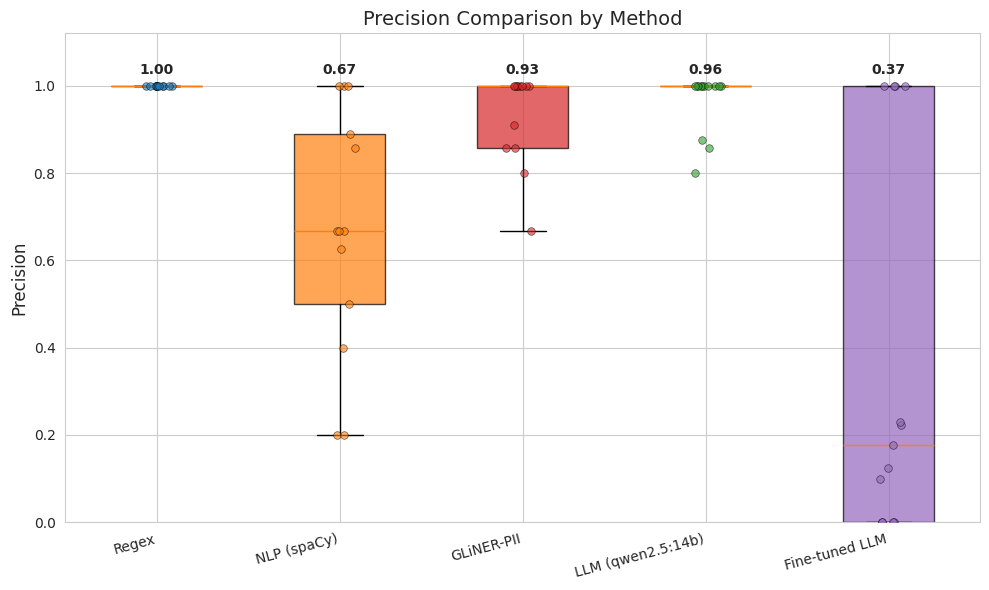

Saved: precision_comparison_boxplot.png


In [110]:
# Precision Comparison Boxplot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

precision_data = [regex_p, nlp_p, pii_p, llm_p, finetuned_p]
bp = ax.boxplot(precision_data, tick_labels=method_names, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual data points with jitter
for i, (data, color) in enumerate(zip(precision_data, colors), 1):
    jitter = np.random.normal(0, 0.04, size=len(data))
    ax.scatter(np.repeat(i, len(data)) + jitter, data, alpha=0.6, color=color, edgecolor='black', linewidth=0.5, s=30, zorder=3)
    # Display average value
    avg = np.mean(data)
    ax.text(i, 1.02, f'{avg:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision Comparison by Method', fontsize=14)
ax.set_ylim(0, 1.12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('precision_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: precision_comparison_boxplot.png")

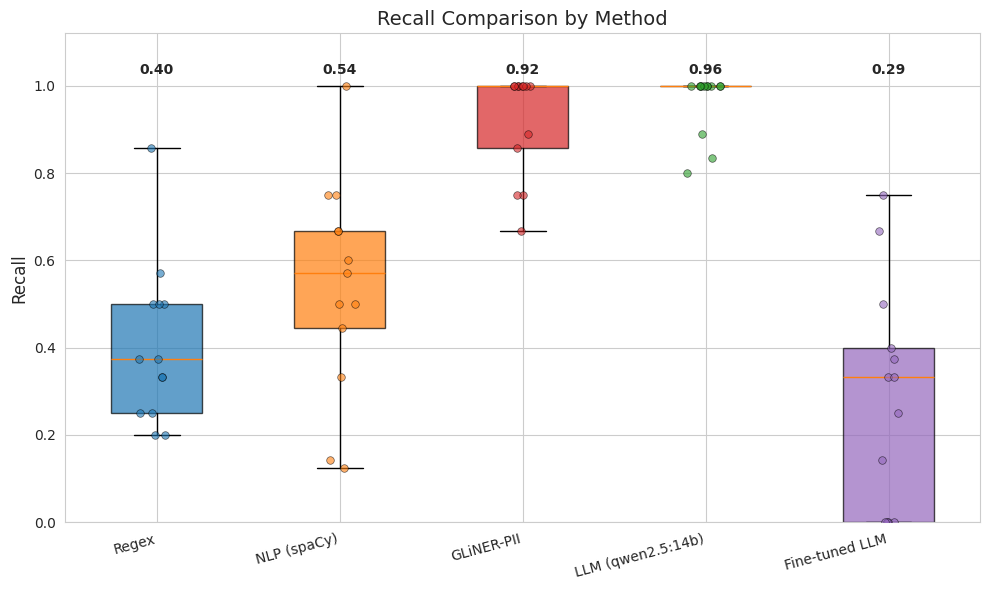

Saved: recall_comparison_boxplot.png


In [111]:
# Recall Comparison Boxplot
fig, ax = plt.subplots(figsize=(10, 6))

recall_data = [regex_r, nlp_r, pii_r, llm_r, finetuned_r]
bp = ax.boxplot(recall_data, tick_labels=method_names, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual data points with jitter
for i, (data, color) in enumerate(zip(recall_data, colors), 1):
    jitter = np.random.normal(0, 0.04, size=len(data))
    ax.scatter(np.repeat(i, len(data)) + jitter, data, alpha=0.6, color=color, edgecolor='black', linewidth=0.5, s=30, zorder=3)
    # Display average value
    avg = np.mean(data)
    ax.text(i, 1.02, f'{avg:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Recall', fontsize=12)
ax.set_title('Recall Comparison by Method', fontsize=14)
ax.set_ylim(0, 1.12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('recall_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: recall_comparison_boxplot.png")

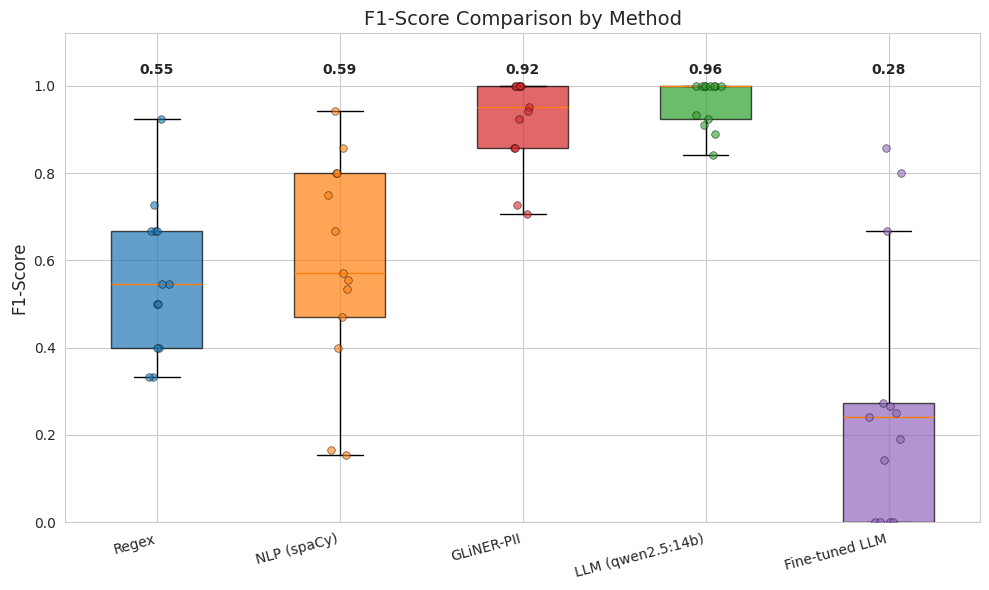

Saved: f1_comparison_boxplot.png


In [112]:
# F1-Score Comparison Boxplot
fig, ax = plt.subplots(figsize=(10, 6))

f1_data = [regex_f1, nlp_f1, pii_f1, llm_f1, finetuned_f1]
bp = ax.boxplot(f1_data, tick_labels=method_names, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual data points with jitter
for i, (data, color) in enumerate(zip(f1_data, colors), 1):
    jitter = np.random.normal(0, 0.04, size=len(data))
    ax.scatter(np.repeat(i, len(data)) + jitter, data, alpha=0.6, color=color, edgecolor='black', linewidth=0.5, s=30, zorder=3)
    # Display average value
    avg = np.mean(data)
    ax.text(i, 1.02, f'{avg:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('F1-Score Comparison by Method', fontsize=14)
ax.set_ylim(0, 1.12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('f1_comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: f1_comparison_boxplot.png")

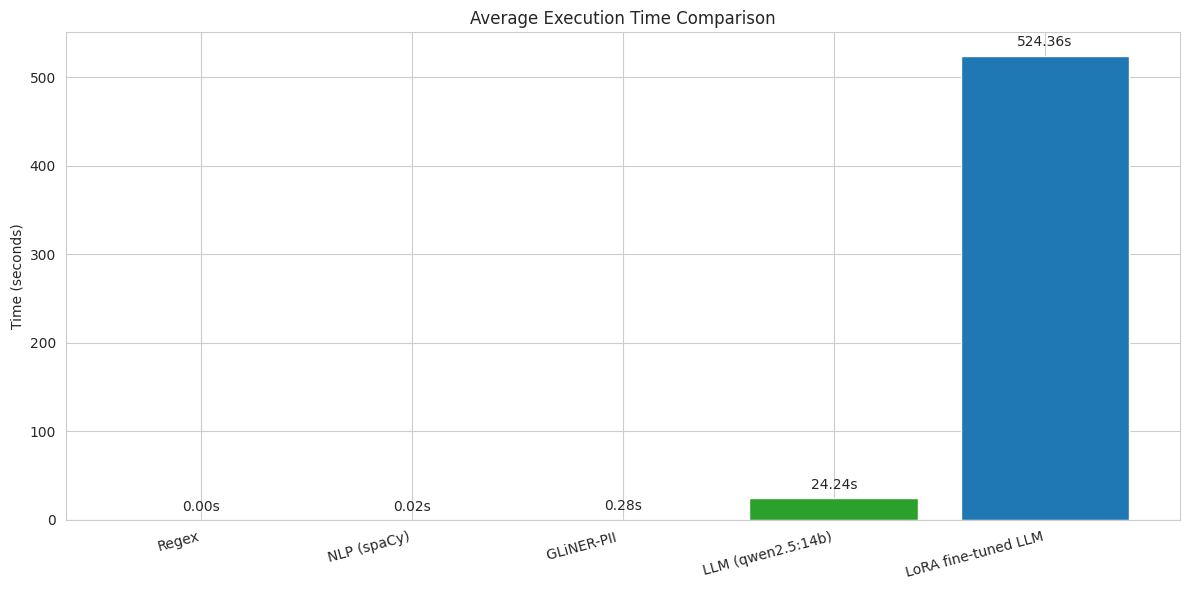

In [113]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c']
bars = ax.bar(methods, comparison_df['Time (seconds)'], color=colors)
ax.set_ylabel('Time (seconds)')
ax.set_title('Average Execution Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')

for i, v in enumerate(comparison_df['Time (seconds)']):
    ax.text(i, v + max(comparison_df['Time (seconds)'])*0.02, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.savefig('method_comparison_time.png', dpi=300, bbox_inches='tight')
plt.show()

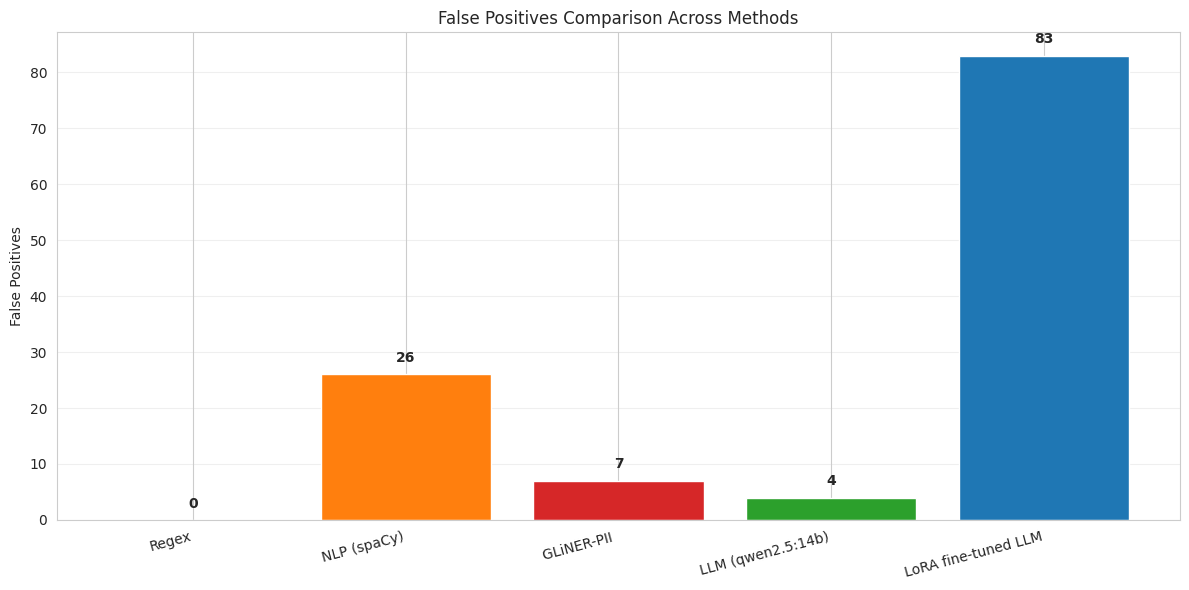

False Positives by Method:
  Regex: 0
  NLP (spaCy): 26
  GLiNER-PII : 7
  LLM (qwen2.5:14b): 4
  LoRA fine-tuned LLM: 83


In [114]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))


fp_values = [
    dataset["regex_metrics"]["fp"],
    dataset["nlp_metrics"]["fp"],
    dataset["PII_metrics"]["fp"],
    dataset["llm_metrics"]["fp"],
    dataset["finetuned_llm_metrics"]["fp"]
]

colors = ["#1f77b4", "#ff7f0e", "#d62728", "#2ca02c"]
bars = ax.bar(methods, fp_values, color=colors)

ax.set_ylabel("False Positives")
ax.set_title("False Positives Comparison Across Methods")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha="right")


for i, v in enumerate(fp_values):
    ax.text(i, v + max(fp_values) * 0.02, f"{int(v)}", ha="center", va="bottom", fontsize=10, fontweight="bold")


ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"False Positives by Method:")
for method, fp in zip(methods, fp_values):
    print(f"  {method}: {int(fp)}")

### 7.3 Method vs IoC Type Heatmap

Compare F1 scores across methods and entity types.

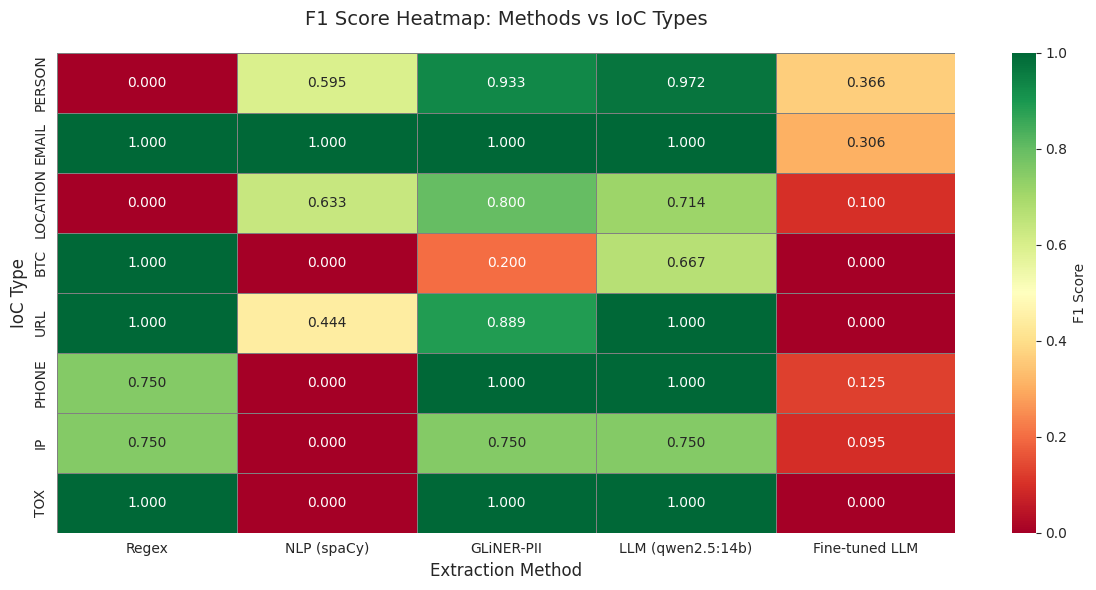

Saved: method_ioc_type_heatmap.png
F1 Scores by Method and IoC Type:
          Regex  NLP (spaCy)  GLiNER-PII  LLM (qwen2.5:14b)  Fine-tuned LLM
PERSON     0.00     0.594705    0.933333           0.971795        0.365743
EMAIL      1.00     1.000000    1.000000           1.000000        0.305556
LOCATION   0.00     0.633333    0.800000           0.714286        0.100000
BTC        1.00     0.000000    0.200000           0.666667        0.000000
URL        1.00     0.444444    0.888889           1.000000        0.000000
PHONE      0.75     0.000000    1.000000           1.000000        0.125000
IP         0.75     0.000000    0.750000           0.750000        0.095238
TOX        1.00     0.000000    1.000000           1.000000        0.000000


In [115]:

methods = ['Regex', 'NLP (spaCy)', 'GLiNER-PII', f'LLM ({best_model})', 'Fine-tuned LLM']
ioc_types = types

f1_matrix = []

for ioc_type in ioc_types:
    type_lower = ioc_type.lower()
    row = [
        dataset['regex_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['nlp_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['PII_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['llm_type_metrics'].get(type_lower, {}).get('f1', 0.0),
        dataset['finetuned_llm_type_metrics'].get(type_lower, {}).get('f1', 0.0)
    ]
    f1_matrix.append(row)


heatmap_df = pd.DataFrame(f1_matrix, index=ioc_types, columns=methods)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'F1 Score'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('F1 Score Heatmap: Methods vs IoC Types', fontsize=14, pad=20)
plt.xlabel('Extraction Method', fontsize=12)
plt.ylabel('IoC Type', fontsize=12)
plt.tight_layout()
plt.savefig('method_ioc_type_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: method_ioc_type_heatmap.png")
print("F1 Scores by Method and IoC Type:")
print(heatmap_df.to_string())

## Section 6: Hybrid IoC Extraction Pipeline

In the results of the previous sections we have seen that LLM-based extraction can achieve high results by achieving an F1 score of 0.95, but for practical law enforcement application this is not high enough. For certain entity types, Regex achieves perfect accuracy but it can still run into false positive (FP) entities based on context (e.g., the URL `http://127.0.0.1`) and false negatives (FN) due to 'defanged' entities.

In this section we discuss how we can integrate current state-of-the-art methods with LLMs to optimize IoC extraction accuracy while minimizing execution time for operational law enforcement contexts.

The focus of this research, which is for law enforcement contexts, is on **accuracy** rather than execution time. We propose a pipeline that maximizes accuracy through multiple NLP method validation in order to increase or decrease confidence of extracted entities.

### Pipeline Architecture

The hybrid pipeline executes in the following steps:

1. **Regex Extraction**: Extract entities of type (BTC, IBAN, URL, EMAIL, IP and TOX) from the document
2. **GLiNER-PII Extraction**: Extract entities of type (PERSON, LOCATION, PHONE) from the document  
3. **LLM Extraction**: Parse the document into sentence snippets and extract all entity types
4. **Confidence Scoring**: Union the three sets of entities and score:
   - **High confidence**: Entity present in 2+ extraction methods
   - **Low confidence**: Entity present in only 1 extraction method

In [33]:
# Define entity type assignments for each extraction method
REGEX_ENTITY_TYPES = {'BTC', 'IBAN', 'URL', 'EMAIL', 'IP', 'TOX'}
GLINER_ENTITY_TYPES = {'PERSON', 'LOCATION', 'PHONE'}
LLM_ENTITY_TYPES = {'EMAIL', 'IP', 'BTC', 'IBAN', 'PERSON', 'LOCATION', 'PHONE', 'URL', 'TOX'}

hybrid_regex_patterns = {et: ioc_patterns.get(et) for et in REGEX_ENTITY_TYPES}

In [34]:
def extract_with_regex_hybrid(text, patterns):

    entities = []
    
    for entity_type, pattern in patterns.items():
        for match in re.finditer(pattern, text, re.IGNORECASE):
            entity = {
                'text': match.group(),
                'type': entity_type.upper(),
                'start_pos': match.start(),
                'end_pos': match.end(),
                'method': 'regex'
            }
            entities.append(entity)
    
    return entities


In [35]:
def extract_with_gliner_hybrid(text, gliner_model, labels):
    entities = []
    
    try:
        pred_entities = gliner_model.predict_entities(text, labels=labels)
        for entity in pred_entities:
            entities.append({
                'text': entity['text'],
                'type': entity['label'].upper(),
                'start_pos': entity['start'],
                'end_pos': entity['end'],
                'method': 'gliner'
            })
    except Exception as e:
        print(f"GLiNER extraction error: {e}")
    
    return entities

In [36]:
def split_text_into_sentences(text, delimiters=['. ', '? ', '! ']):
    # Split text into sentences and track positions in full text
    sentence_segments = [(text, 0, len(text))]
    for delimiter in delimiters:
        new_segments = []
        for sent, sent_start_pos, sent_end_pos in sentence_segments:
            current_pos = 0
            while current_pos < len(sent):
                next_delim_pos = sent.find(delimiter, current_pos)
                if next_delim_pos == -1:
                    remaining = sent[current_pos:]
                    if remaining.strip():
                        new_segments.append((
                            remaining.strip(), 
                            sent_start_pos + current_pos + len(remaining) - len(remaining.strip()),
                            sent_end_pos
                            ))
                    break
                else:
                    segment = sent[current_pos:next_delim_pos + len(delimiter)]
                    if segment.strip():
                        new_segments.append((
                            segment.strip(), 
                            sent_start_pos + current_pos + len(segment) - len(segment.strip()), 
                            sent_start_pos + next_delim_pos + len(delimiter)))
                current_pos = next_delim_pos + len(delimiter)
        sentence_segments = new_segments if new_segments else sentence_segments
    return sentence_segments

In [37]:
def extract_with_llm_hybrid(text, model_name, prompt, options, sentence_delimiters=['. ', '? ', '! ']):
    entities = []
    sentence_segments = split_text_into_sentences(text, delimiters=sentence_delimiters)

    for sent, sent_start_pos, sent_end_pos in sentence_segments:
        if not sent.strip():
            continue

        try:
            parsed, elapsed_time = chat(model_name, prompt, sent, options)

            if parsed and 'entities' in parsed:
                for ent in parsed['entities']:
                    entity_text = ent.get('entity', ent.get('text', ''))
                    entity_type = ent.get('type', '').upper()

                    start_pos, end_pos = find_entity_position(entity_text, text, start_search=sent_start_pos)

                    entities.append({
                        'text': entity_text,
                        'type': entity_type,
                        'start_pos': start_pos,
                        'end_pos': end_pos,
                        'method': 'llm'
                    })
        except Exception as e:
            print(f"LLM extraction error for sentence: {e}")
    return entities

In [38]:
def entities_match(ent1, ent2, similarity_threshold=0.8):
    # Types must match
    if ent1['type'].upper() != ent2['type'].upper():
        return False

    # If BOTH entities have valid positions, check positions FIRST
    has_pos1 = ent1.get('start_pos', -1) != -1
    has_pos2 = ent2.get('start_pos', -1) != -1

    if has_pos1 and has_pos2:
        start1, end1 = ent1['start_pos'], ent1['end_pos']
        start2, end2 = ent2['start_pos'], ent2['end_pos']

        # Calculate overlap
        overlap_start = max(start1, start2)
        overlap_end = min(end1, end2)

        if overlap_start < overlap_end:
            # Has position overlap - check if it's significant
            overlap = overlap_end - overlap_start
            len1 = end1 - start1
            len2 = end2 - start2
            overlap_ratio = overlap / min(len1, len2) if min(len1, len2) > 0 else 0

            # If significant position overlap AND similar text, it's a match
            if overlap_ratio >= 0.5:
                ratio = SequenceMatcher(None, ent1['text'].lower(), ent2['text'].lower()).ratio()
                return ratio >= similarity_threshold
            
        return False

    if ent1['text'].lower() == ent2['text'].lower():
        return True

    # Fuzzy text matching
    ratio = SequenceMatcher(None, ent1['text'].lower(), ent2['text'].lower()).ratio()
    return ratio >= similarity_threshold

In [39]:
def calculate_confidence_scores(regex_entities, gliner_entities, llm_entities):
    print('regex_entities:\n', regex_entities,'\n', 'gliner_entities:\n', gliner_entities,'\n', 'llm_entities:\n', llm_entities)
    all_entities = []

    # Combine all entities with their source method
    for ent in regex_entities:
        ent['source_methods'] = ['regex']
        all_entities.append(ent)

    for ent in gliner_entities:
        ent['source_methods'] = ['gliner']
        all_entities.append(ent)

    for ent in llm_entities:
        ent['source_methods'] = ['llm']
        all_entities.append(ent)

    # Merge matching entities
    merged_entities = []
    used_indices = []

    for i, ent1 in enumerate(all_entities):
        if i in used_indices:
            continue

        merged_entity = {
            'text': ent1['text'],
            'type': ent1['type'],
            'start_pos': ent1.get('start_pos', -1),
            'end_pos': ent1.get('end_pos', -1),
            'methods': ent1['source_methods']
        }
        used_indices.append(i)

        # Find matching entities
        for j, ent2 in enumerate(all_entities):
            if j in used_indices:
                continue

            if entities_match(ent1, ent2):
                merged_entity['methods'].append(ent2['source_methods'])
                # Use position from most reliable source (prefer regex/gliner over llm)
                if merged_entity['start_pos'] == -1 and ent2.get('start_pos', -1) != -1:
                    merged_entity['start_pos'] = ent2['start_pos']
                    merged_entity['end_pos'] = ent2['end_pos']
                used_indices.append(j)

        # Assign confidence based on number of methods
        num_methods = len(merged_entity['methods'])
        merged_entity['confidence'] = 'high' if num_methods >= 2 else 'low'
        merged_entity['num_methods'] = num_methods
        merged_entity['methods'] = list(merged_entity['methods'])

        merged_entities.append(merged_entity)

    return merged_entities

In [40]:
def hybrid_extraction_pipeline(text, gliner_model, llm_model_name, llm_prompt, llm_options):

    timing = {}
    
    # Step 1: Regex extraction
    start_time = datetime.now()
    regex_entities = extract_with_regex_hybrid(text, hybrid_regex_patterns)
    timing['regex'] = (datetime.now() - start_time).total_seconds()
    print(f"Step 1 - Regex: Extracted {len(regex_entities)} entities in {timing['regex']:.4f}s")
    
    # Step 2: GLiNER extraction
    start_time = datetime.now()
    gliner_entities = extract_with_gliner_hybrid(text, gliner_model, GLINER_ENTITY_TYPES)
    timing['gliner'] = (datetime.now() - start_time).total_seconds()
    print(f"Step 2 - GLiNER: Extracted {len(gliner_entities)} entities in {timing['gliner']:.4f}s")
    
    # Step 3: LLM extraction
    start_time = datetime.now()
    llm_entities = extract_with_llm_hybrid(text, llm_model_name, llm_prompt, llm_options)
    timing['llm'] = (datetime.now() - start_time).total_seconds()
    print(f"Step 3 - LLM: Extracted {len(llm_entities)} entities in {timing['llm']:.4f}s")
    
    # Step 4: Union and confidence scoring
    start_time = datetime.now()
    final_entities = calculate_confidence_scores(
        regex_entities.copy(), 
        gliner_entities.copy(), 
        llm_entities.copy()
    )
    timing['scoring'] = (datetime.now() - start_time).total_seconds()
    timing['total'] = sum(timing.values())
    
    # Count confidence levels
    high_conf = sum(1 for e in final_entities if e['confidence'] == 'high')
    low_conf = sum(1 for e in final_entities if e['confidence'] == 'low')
    
    print(f"\nStep 4 - Confidence Scoring:")
    print(f"  Total unique entities: {len(final_entities)}")
    print(f"  High confidence: {high_conf}")
    print(f"  Low confidence: {low_conf}")
    print(f"\nTotal pipeline time: {timing['total']:.4f}s")
    
    return {
        'entities': final_entities,
        'regex_entities': regex_entities,
        'gliner_entities': gliner_entities,
        'llm_entities': llm_entities,
        'timing': timing,
        'high_confidence_count': high_conf,
        'low_confidence_count': low_conf
    }

### Run Hybrid Pipeline on Dataset

Execute the hybrid extraction pipeline on the test documents and evaluate performance.

In [54]:
print(dataset['text'][0])

Curiosity piqued, Anna replied quickly using her secondary account:
From: ahargrove92@pm.me
To: m.grant512@tuta.io
I'm intrigued. Send everything you have.
– Anna



In [55]:
hybrid_extraction_pipeline(
        text=dataset['text'][0],
        gliner_model=model, 
        llm_model_name=best_model,
        llm_prompt=final_prompt,
        llm_options=options
    )

Step 1 - Regex: Extracted 2 entities in 0.0001s
Step 2 - GLiNER: Extracted 2 entities in 0.2551s
Error during LLM call or processing: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download
Retrying... (1/3)
Error during LLM call or processing: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download
Retrying... (2/3)
Error during LLM call or processing: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download
Retrying... (3/3)
Error during LLM call or processing: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download
Retrying... (1/3)
Error during LLM call or processing: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download
Retrying... (2/3)
Error during LLM call o

{'entities': [{'text': 'ahargrove92@pm.me',
   'type': 'EMAIL',
   'start_pos': 74,
   'end_pos': 91,
   'methods': ['regex'],
   'confidence': 'low',
   'num_methods': 1},
  {'text': 'm.grant512@tuta.io',
   'type': 'EMAIL',
   'start_pos': 96,
   'end_pos': 114,
   'methods': ['regex'],
   'confidence': 'low',
   'num_methods': 1},
  {'text': 'Anna',
   'type': 'PERSON',
   'start_pos': 18,
   'end_pos': 22,
   'methods': ['gliner'],
   'confidence': 'low',
   'num_methods': 1},
  {'text': 'Anna',
   'type': 'PERSON',
   'start_pos': 158,
   'end_pos': 162,
   'methods': ['gliner'],
   'confidence': 'low',
   'num_methods': 1}],
 'regex_entities': [{'text': 'ahargrove92@pm.me',
   'type': 'EMAIL',
   'start_pos': 74,
   'end_pos': 91,
   'method': 'regex',
   'source_methods': ['regex']},
  {'text': 'm.grant512@tuta.io',
   'type': 'EMAIL',
   'start_pos': 96,
   'end_pos': 114,
   'method': 'regex',
   'source_methods': ['regex']}],
 'gliner_entities': [{'text': 'Anna',
   'type': '

In [56]:
hybrid_results = []

print(f"Running hybrid pipeline with LLM model: {best_model}")
print("=" * 60)

for idx, row in enumerate(dataset['text']):
    print(f"\n--- Document {idx + 1}/{len(dataset['text'])} ---")
    
    result = hybrid_extraction_pipeline(
        text=row,
        gliner_model=model, 
        llm_model_name=best_model,
        llm_prompt=final_prompt,
        llm_options=options
    )
    
    # Calculate metrics against ground truth
    gt_entities = dataset['gt_entities'][idx] if 'gt_entities' in dataset else []
    
    # Metrics for all entities
    all_metrics = calculate_ner_metrics(
        result['entities'],
        gt_entities,
        match_type='partial'
    )
    
    # Metrics for high confidence only
    high_conf_entities = [e for e in result['entities'] if e['confidence'] == 'high']
    high_conf_metrics = calculate_ner_metrics(
        high_conf_entities,
        gt_entities,
        match_type='partial'
    )
    
    result.update({
        'document_idx': idx,
        'all_precision': all_metrics['precision'],
        'all_recall': all_metrics['recall'],
        'all_f1': all_metrics['f1'],
        'high_conf_precision': high_conf_metrics['precision'],
        'high_conf_recall': high_conf_metrics['recall'],
        'high_conf_f1': high_conf_metrics['f1'],
        'gt_entities': gt_entities
    })
    
    hybrid_results.append(result)

print("\n" + "=" * 60)
print("Hybrid pipeline execution complete!")

Running hybrid pipeline with LLM model: qwen2.5:14b

--- Document 1/13 ---
Step 1 - Regex: Extracted 2 entities in 0.0001s
Step 2 - GLiNER: Extracted 2 entities in 0.3134s
Step 3 - LLM: Extracted 4 entities in 44.4579s
regex_entities:
 [{'text': 'ahargrove92@pm.me', 'type': 'EMAIL', 'start_pos': 74, 'end_pos': 91, 'method': 'regex'}, {'text': 'm.grant512@tuta.io', 'type': 'EMAIL', 'start_pos': 96, 'end_pos': 114, 'method': 'regex'}] 
 gliner_entities:
 [{'text': 'Anna', 'type': 'PERSON', 'start_pos': 18, 'end_pos': 22, 'method': 'gliner'}, {'text': 'Anna', 'type': 'PERSON', 'start_pos': 158, 'end_pos': 162, 'method': 'gliner'}] 
 llm_entities:
 [{'text': 'ahargrove92@pm.me', 'type': 'EMAIL', 'start_pos': 74, 'end_pos': 91, 'method': 'llm'}, {'text': 'm.grant512@tuta.io', 'type': 'EMAIL', 'start_pos': 96, 'end_pos': 114, 'method': 'llm'}, {'text': 'Anna', 'type': 'PERSON', 'start_pos': 18, 'end_pos': 22, 'method': 'llm'}, {'text': 'Anna', 'type': 'PERSON', 'start_pos': 158, 'end_pos': 1

### Hybrid Pipeline Results Analysis

Analyze the performance of the hybrid extraction pipeline and compare confidence-based filtering.

In [57]:
# Create results DataFrame
hybrid_df = pd.DataFrame([{
    'document': r['document_idx'],
    'total_entities': len(r['entities']),
    'entities': r['entities'],
    'gt_entities': r['gt_entities'],
    'high_confidence': r['high_confidence_count'],
    'low_confidence': r['low_confidence_count'],
    'regex_count': len(r['regex_entities']),
    'gliner_count': len(r['gliner_entities']),
    'llm_count': len(r['llm_entities']),
    'all_precision': r['all_precision'],
    'all_recall': r['all_recall'],
    'all_f1': r['all_f1'],
    'high_conf_precision': r['high_conf_precision'],
    'high_conf_recall': r['high_conf_recall'],
    'high_conf_f1': r['high_conf_f1'],
    'total_time': r['timing']['total'],
    'regex_time': r['timing']['regex'],
    'gliner_time': r['timing']['gliner'],
    'llm_time': r['timing']['llm']
} for r in hybrid_results])

# Summary statistics
print("=== Hybrid Pipeline Performance Summary ===\n")
print("Overall Metrics (All Entities):")
print(f"  Mean Precision: {hybrid_df['all_precision'].mean():.4f}")
print(f"  Mean Recall:    {hybrid_df['all_recall'].mean():.4f}")
print(f"  Mean F1 Score:  {hybrid_df['all_f1'].mean():.4f}")

print("\nHigh Confidence Entities Only:")
print(f"  Mean Precision: {hybrid_df['high_conf_precision'].mean():.4f}")
print(f"  Mean Recall:    {hybrid_df['high_conf_recall'].mean():.4f}")
print(f"  Mean F1 Score:  {hybrid_df['high_conf_f1'].mean():.4f}")

print("\nEntity Counts:")
print(f"  Total entities extracted: {hybrid_df['total_entities'].sum()}")
print(f"  High confidence:          {hybrid_df['high_confidence'].sum()} ({100*hybrid_df['high_confidence'].sum()/hybrid_df['total_entities'].sum():.1f}%)")
print(f"  Low confidence:           {hybrid_df['low_confidence'].sum()} ({100*hybrid_df['low_confidence'].sum()/hybrid_df['total_entities'].sum():.1f}%)")

print("\nTiming Statistics:")
print(f"  Mean total time:  {hybrid_df['total_time'].mean():.4f}s")
print(f"  Mean regex time:  {hybrid_df['regex_time'].mean():.4f}s")
print(f"  Mean GLiNER time: {hybrid_df['gliner_time'].mean():.4f}s")
print(f"  Mean LLM time:    {hybrid_df['llm_time'].mean():.4f}s")

hybrid_df

=== Hybrid Pipeline Performance Summary ===

Overall Metrics (All Entities):
  Mean Precision: 0.9026
  Mean Recall:    1.0000
  Mean F1 Score:  0.9448

High Confidence Entities Only:
  Mean Precision: 0.9872
  Mean Recall:    0.8052
  Mean F1 Score:  0.8788

Entity Counts:
  Total entities extracted: 100
  High confidence:          70 (70.0%)
  Low confidence:           30 (30.0%)

Timing Statistics:
  Mean total time:  23.4309s
  Mean regex time:  0.0004s
  Mean GLiNER time: 0.6267s
  Mean LLM time:    22.8030s


,document,total_entities,entities,gt_entities,high_confidence,low_confidence,regex_count,gliner_count,llm_count,all_precision,all_recall,all_f1,high_conf_precision,high_conf_recall,high_conf_f1,total_time,regex_time,gliner_time,llm_time
0,0,4,"[{'text': 'ahargrove92@pm.me', 'type': 'EMAIL'...","[{'startOffset': 18, 'endOffset': 22, 'type': ...",4,0,2,2,4,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,44.771869,0.000138,0.313430,44.457872
1,1,11,"[{'text': 'marcellus.grant@protonmail.com', 't...","[{'startOffset': 5, 'endOffset': 18, 'type': '...",6,5,3,6,8,0.727273,1.0,0.842105,1.000000,0.750000,0.857143,24.106535,0.000447,0.396170,23.709426
2,2,4,[{'text': 'bc1q2gdf0hxk6e5nxp72cr9sv5uwx9a0gz0...,"[{'startOffset': 49, 'endOffset': 53, 'type': ...",3,1,1,3,4,1.000000,1.0,1.000000,1.000000,0.750000,0.857143,13.909429,0.000199,0.875075,13.033818
3,3,8,"[{'text': 'c.varga@journalisttruth.org', 'type...","[{'startOffset': 0, 'endOffset': 8, 'type': 'P...",5,3,2,5,6,0.750000,1.0,0.857143,1.000000,0.833333,0.909091,12.022962,0.000173,0.383108,11.639267
4,4,6,[{'text': 'bc1qt5vmgkz06c4q6z3trw8gkfj0y7n07gq...,"[{'startOffset': 41, 'endOffset': 61, 'type': ...",5,1,3,3,5,1.000000,1.0,1.000000,1.000000,0.833333,0.909091,18.922910,0.000212,0.311573,18.610561
5,5,10,"[{'text': 'contact@unitedchange.org', 'type': ...","[{'startOffset': 33, 'endOffset': 41, 'type': ...",6,4,2,8,8,1.000000,1.0,1.000000,1.000000,0.600000,0.750000,36.629418,0.000343,0.850205,35.778408
6,6,5,"[{'text': 'm.grant512@tuta.io', 'type': 'EMAIL...","[{'startOffset': 132, 'endOffset': 140, 'type'...",5,0,1,4,5,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,16.738573,0.000210,0.707587,16.029842
7,7,8,"[{'text': 'm.grant512@tuta.io', 'type': 'EMAIL...","[{'startOffset': 6, 'endOffset': 24, 'type': '...",4,4,2,3,8,1.000000,1.0,1.000000,1.000000,0.500000,0.666667,19.805722,0.000821,2.034932,17.769522
8,8,10,"[{'text': 'cleanup.operations@securemail.ch', ...","[{'startOffset': 63, 'endOffset': 110, 'type':...",7,3,3,5,10,0.900000,1.0,0.947368,1.000000,0.777778,0.875000,30.373941,0.000432,0.917629,29.454284
9,9,7,[{'text': 'http://darkmatter7x4j3k.onion/forum...,"[{'startOffset': 35, 'endOffset': 39, 'type': ...",6,1,2,5,7,0.857143,1.0,0.923077,0.833333,0.833333,0.833333,19.537054,0.000565,0.432468,19.102930


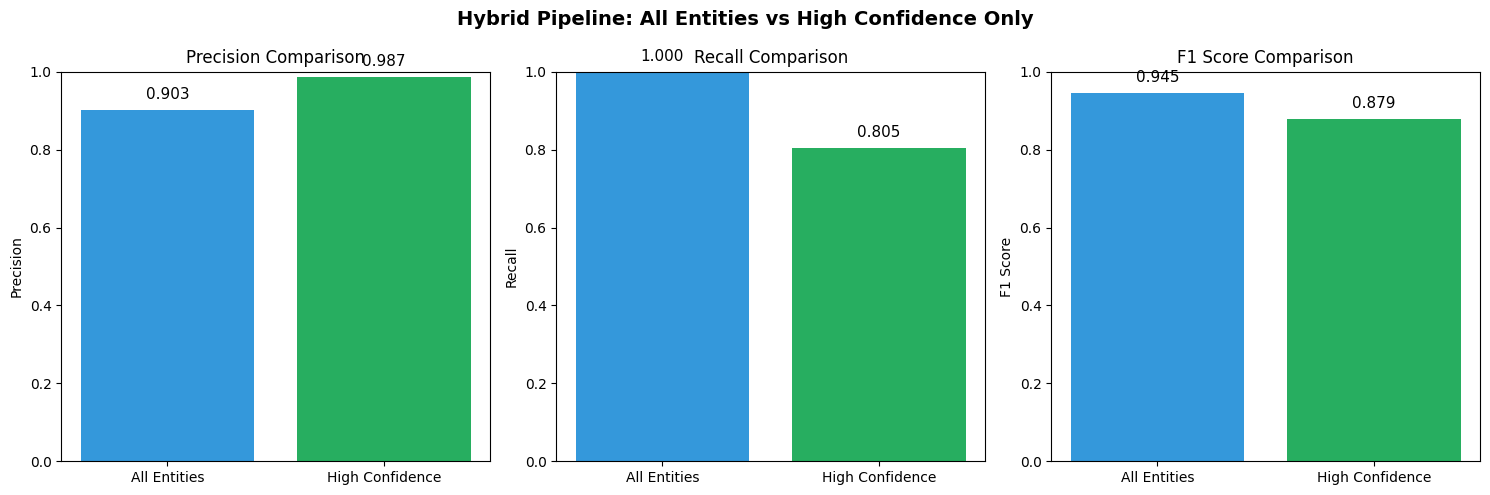

In [58]:
# Visualization: Compare All vs High Confidence metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision comparison
ax1 = axes[0]
metrics_precision = [hybrid_df['all_precision'].mean(), hybrid_df['high_conf_precision'].mean()]
bars1 = ax1.bar(['All Entities', 'High Confidence'], metrics_precision, color=['#3498db', '#27ae60'])
ax1.set_ylabel('Precision')
ax1.set_title('Precision Comparison')
ax1.set_ylim(0, 1)
for bar, val in zip(bars1, metrics_precision):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=11)

# Recall comparison
ax2 = axes[1]
metrics_recall = [hybrid_df['all_recall'].mean(), hybrid_df['high_conf_recall'].mean()]
bars2 = ax2.bar(['All Entities', 'High Confidence'], metrics_recall, color=['#3498db', '#27ae60'])
ax2.set_ylabel('Recall')
ax2.set_title('Recall Comparison')
ax2.set_ylim(0, 1)
for bar, val in zip(bars2, metrics_recall):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=11)

# F1 comparison
ax3 = axes[2]
metrics_f1 = [hybrid_df['all_f1'].mean(), hybrid_df['high_conf_f1'].mean()]
bars3 = ax3.bar(['All Entities', 'High Confidence'], metrics_f1, color=['#3498db', '#27ae60'])
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score Comparison')
ax3.set_ylim(0, 1)
for bar, val in zip(bars3, metrics_f1):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', 
             ha='center', va='bottom', fontsize=11)

plt.suptitle('Hybrid Pipeline: All Entities vs High Confidence Only', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

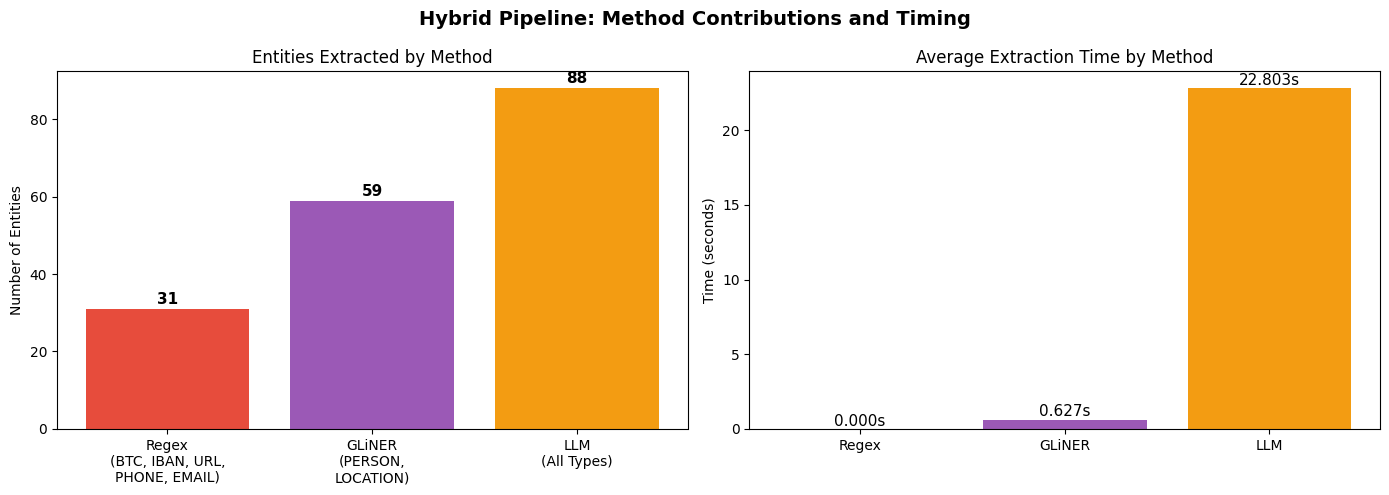

In [60]:
# Visualization: Method contributions and timing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entity counts by method
ax1 = axes[0]
method_counts = [
    hybrid_df['regex_count'].sum(),
    hybrid_df['gliner_count'].sum(),
    hybrid_df['llm_count'].sum()
]
colors = ['#e74c3c', '#9b59b6', '#f39c12']
bars = ax1.bar(['Regex\n(BTC, IBAN, URL,\nPHONE, EMAIL)', 
                'GLiNER\n(PERSON,\nLOCATION)', 
                'LLM\n(All Types)'], 
               method_counts, color=colors)
ax1.set_ylabel('Number of Entities')
ax1.set_title('Entities Extracted by Method')
for bar, val in zip(bars, method_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(val), 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Timing breakdown
ax2 = axes[1]
timing_data = [
    hybrid_df['regex_time'].mean(),
    hybrid_df['gliner_time'].mean(),
    hybrid_df['llm_time'].mean()
]
bars2 = ax2.bar(['Regex', 'GLiNER', 'LLM'], timing_data, color=colors)
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Average Extraction Time by Method')
for bar, val in zip(bars2, timing_data):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}s', 
             ha='center', va='bottom', fontsize=11)

plt.suptitle('Hybrid Pipeline: Method Contributions and Timing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

=== Confidence Distribution by Entity Type ===
confidence  high  low
type                 
BTC            3    1
EMAIL         15    0
IP             5    0
LOCATION       9    4
PERSON        27    4
PHONE          4    1
TOX            3    0
URL            5    0



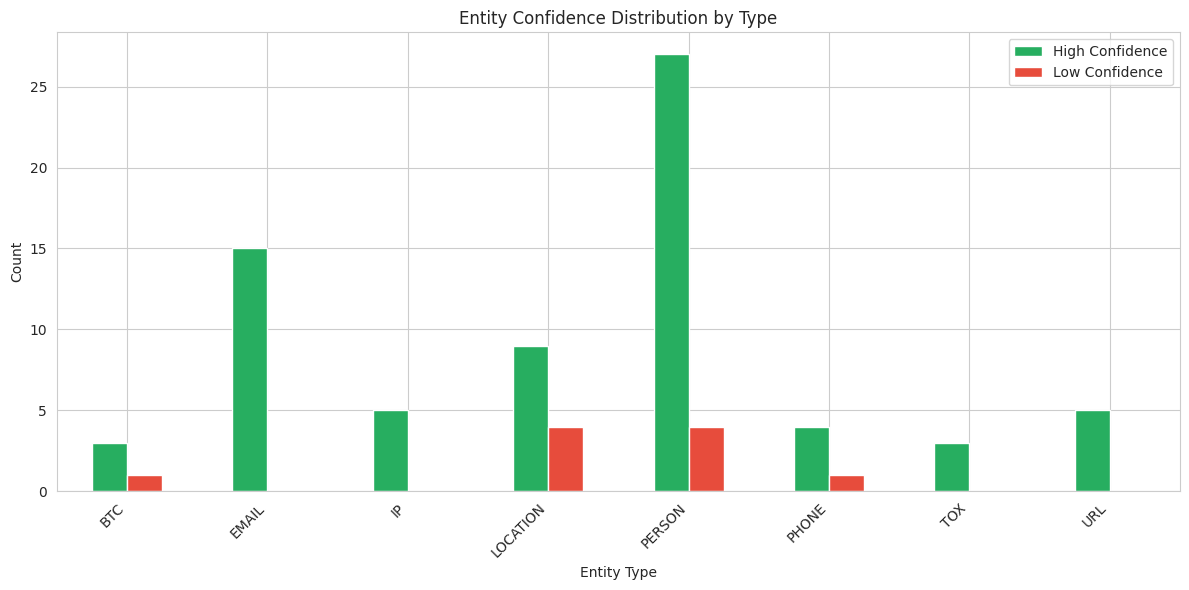


=== Sample High Confidence Entities ===
                                      text     type confidence  num_methods      methods
                         ahargrove92@pm.me    EMAIL       high            2     regexllm
                        m.grant512@tuta.io    EMAIL       high            2     regexllm
                                      Anna   PERSON       high            4 glinergliner
            marcellus.grant@protonmail.com    EMAIL       high            2     regexllm
                     anna.h@techparadox.io    EMAIL       high            2     regexllm
                        m.grant512@tuta.io    EMAIL       high            2     regexllm
                                      Anna   PERSON       high            4 glinergliner
                                  Brooklyn LOCATION       high            2    glinerllm
                           Marcellus Grant   PERSON       high            2    glinerllm
                                    Prague LOCATION       high       

In [168]:
# Analyze entity confidence by type
all_entities = []
for r in hybrid_results:
    for ent in r['entities']:
        all_entities.append({
            'text': ent['text'],
            'type': ent['type'],
            'confidence': ent['confidence'],
            'num_methods': ent['num_methods'],
            'methods': ent['methods'][0] + ent['methods'][1][0] if len(ent['methods']) > 1 else ' '
        })

entities_df = pd.DataFrame(all_entities)

# Confidence distribution by entity type
confidence_by_type = entities_df.groupby(['type', 'confidence']).size().unstack(fill_value=0)
print("=== Confidence Distribution by Entity Type ===")
print(confidence_by_type)
print()

# Visualize confidence by type
fig, ax = plt.subplots(figsize=(12, 6))
confidence_by_type.plot(kind='bar', ax=ax, color=['#27ae60', '#e74c3c'])
ax.set_xlabel('Entity Type')
ax.set_ylabel('Count')
ax.set_title('Entity Confidence Distribution by Type')
ax.legend(['High Confidence', 'Low Confidence'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show sample high confidence entities
print("\n=== Sample High Confidence Entities ===")
high_conf_sample = entities_df[entities_df['confidence'] == 'high'].head(20)
print(high_conf_sample.to_string(index=False))

# Lets do the contileaks

In [62]:
annotated_contileaks = pd.read_csv('ioc_annotations_contileaks.csv')
annotated_contileaks['gt_entities'] = annotated_contileaks['gt_entities'].apply(ast.literal_eval)

In [63]:
annotated_contileaks['gt_entities'][1]

[]

In [64]:
hybrid_results = []

print(f"Running hybrid pipeline with LLM model: {best_model}")
print("=" * 60)

for idx, row in enumerate(annotated_contileaks['text']):
    print(f"\n--- Document {idx + 1}/{len(annotated_contileaks['text'])} ---")
    
    result = hybrid_extraction_pipeline(
        text=row,
        gliner_model=model, 
        llm_model_name=best_model,
        llm_prompt=final_prompt,
        llm_options=options
    )
    
    # Calculate metrics against ground truth
    gt_entities = annotated_contileaks['gt_entities'][idx]
    
    # Metrics for all entities
    all_metrics = calculate_ner_metrics(
        result['entities'],
        gt_entities,
        match_type='partial'
    )
    
    # Metrics for high confidence only
    high_conf_entities = [e for e in result['entities'] if e['confidence'] == 'high']
    high_conf_metrics = calculate_ner_metrics(
        high_conf_entities,
        gt_entities,
        match_type='partial'
    )
    
    result.update({
        'document_idx': idx,
        'all_precision': all_metrics['precision'],
        'all_recall': all_metrics['recall'],
        'all_f1': all_metrics['f1'],
        'high_conf_precision': high_conf_metrics['precision'],
        'high_conf_recall': high_conf_metrics['recall'],
        'high_conf_f1': high_conf_metrics['f1'],
        'gt_entities': gt_entities
    })
    
    hybrid_results.append(result)

print("\n" + "=" * 60)
print("Hybrid pipeline execution complete!")

Running hybrid pipeline with LLM model: qwen2.5:14b

--- Document 1/518 ---
Step 1 - Regex: Extracted 0 entities in 0.0000s
Step 2 - GLiNER: Extracted 1 entities in 0.1522s
Step 3 - LLM: Extracted 0 entities in 0.9561s
regex_entities:
 [] 
 gliner_entities:
 [{'text': 'Hey', 'type': 'PERSON', 'start_pos': 0, 'end_pos': 3, 'method': 'gliner'}] 
 llm_entities:
 []

Step 4 - Confidence Scoring:
  Total unique entities: 1
  High confidence: 0
  Low confidence: 1

Total pipeline time: 1.1084s

--- Document 2/518 ---
Step 1 - Regex: Extracted 0 entities in 0.0000s
Step 2 - GLiNER: Extracted 1 entities in 0.1158s
Step 3 - LLM: Extracted 0 entities in 0.9172s
regex_entities:
 [] 
 gliner_entities:
 [{'text': 'Hey', 'type': 'PERSON', 'start_pos': 0, 'end_pos': 3, 'method': 'gliner'}] 
 llm_entities:
 []

Step 4 - Confidence Scoring:
  Total unique entities: 1
  High confidence: 0
  Low confidence: 1

Total pipeline time: 1.0330s

--- Document 3/518 ---
Step 1 - Regex: Extracted 0 entities in 0.

/home/jovyan/.local/lib/python3.10/site-packages/gliner/data_processing/processor.py:372: UserWarning: Sentence of length 386 has been truncated to 384
  batch = [self.preprocess_example(b["tokenized_text"], b[key], class_to_ids) for b in batch_list]


Step 2 - GLiNER: Extracted 1 entities in 0.5578s
Step 3 - LLM: Extracted 2 entities in 4.6247s
regex_entities:
 [] 
 gliner_entities:
 [{'text': 'lumius', 'type': 'PERSON', 'start_pos': 20, 'end_pos': 26, 'method': 'gliner'}] 
 llm_entities:
 [{'text': 'lumius', 'type': 'PERSON', 'start_pos': 20, 'end_pos': 26, 'method': 'llm'}, {'text': '4 times', 'type': 'PHONE', 'start_pos': 280, 'end_pos': 287, 'method': 'llm'}]

Step 4 - Confidence Scoring:
  Total unique entities: 2
  High confidence: 1
  Low confidence: 1

Total pipeline time: 5.1837s

--- Document 347/518 ---
Step 1 - Regex: Extracted 0 entities in 0.0001s
Step 2 - GLiNER: Extracted 0 entities in 0.1308s
Step 3 - LLM: Extracted 0 entities in 0.9837s
regex_entities:
 [] 
 gliner_entities:
 [] 
 llm_entities:
 []

Step 4 - Confidence Scoring:
  Total unique entities: 0
  High confidence: 0
  Low confidence: 0

Total pipeline time: 1.1148s

--- Document 348/518 ---
Step 1 - Regex: Extracted 0 entities in 0.0001s
Step 2 - GLiNER: E

In [65]:
# Create results DataFrame
hybrid_df = pd.DataFrame([{
    'document': r['document_idx'],
    'total_entities': len(r['entities']),
    'entities': r['entities'],
    'gt_entities': r['gt_entities'],
    'high_confidence': r['high_confidence_count'],
    'low_confidence': r['low_confidence_count'],
    'regex_count': len(r['regex_entities']),
    'gliner_count': len(r['gliner_entities']),
    'llm_count': len(r['llm_entities']),
    'all_precision': r['all_precision'],
    'all_recall': r['all_recall'],
    'all_f1': r['all_f1'],
    'high_conf_precision': r['high_conf_precision'],
    'high_conf_recall': r['high_conf_recall'],
    'high_conf_f1': r['high_conf_f1'],
    'total_time': r['timing']['total'],
    'regex_time': r['timing']['regex'],
    'gliner_time': r['timing']['gliner'],
    'llm_time': r['timing']['llm']
} for r in hybrid_results])

# Summary statistics
print("=== Hybrid Pipeline Performance Summary ===\n")
print("Overall Metrics (All Entities):")
print(f"  Mean Precision: {hybrid_df['all_precision'].mean():.4f}")
print(f"  Mean Recall:    {hybrid_df['all_recall'].mean():.4f}")
print(f"  Mean F1 Score:  {hybrid_df['all_f1'].mean():.4f}")

print("\nHigh Confidence Entities Only:")
print(f"  Mean Precision: {hybrid_df['high_conf_precision'].mean():.4f}")
print(f"  Mean Recall:    {hybrid_df['high_conf_recall'].mean():.4f}")
print(f"  Mean F1 Score:  {hybrid_df['high_conf_f1'].mean():.4f}")

print("\nEntity Counts:")
print(f"  Total entities extracted: {hybrid_df['total_entities'].sum()}")
print(f"  High confidence:          {hybrid_df['high_confidence'].sum()} ({100*hybrid_df['high_confidence'].sum()/hybrid_df['total_entities'].sum():.1f}%)")
print(f"  Low confidence:           {hybrid_df['low_confidence'].sum()} ({100*hybrid_df['low_confidence'].sum()/hybrid_df['total_entities'].sum():.1f}%)")

print("\nTiming Statistics:")
print(f"  Mean total time:  {hybrid_df['total_time'].mean():.4f}s")
print(f"  Mean regex time:  {hybrid_df['regex_time'].mean():.4f}s")
print(f"  Mean GLiNER time: {hybrid_df['gliner_time'].mean():.4f}s")
print(f"  Mean LLM time:    {hybrid_df['llm_time'].mean():.4f}s")

hybrid_df

=== Hybrid Pipeline Performance Summary ===

Overall Metrics (All Entities):
  Mean Precision: 0.7938
  Mean Recall:    0.8179
  Mean F1 Score:  0.7981

High Confidence Entities Only:
  Mean Precision: 0.9440
  Mean Recall:    0.9414
  Mean F1 Score:  0.9421

Entity Counts:
  Total entities extracted: 185
  High confidence:          48 (25.9%)
  Low confidence:           137 (74.1%)

Timing Statistics:
  Mean total time:  1.3337s
  Mean regex time:  0.0001s
  Mean GLiNER time: 0.1424s
  Mean LLM time:    1.1912s


,document,total_entities,entities,gt_entities,high_confidence,low_confidence,regex_count,gliner_count,llm_count,all_precision,all_recall,all_f1,high_conf_precision,high_conf_recall,high_conf_f1,total_time,regex_time,gliner_time,llm_time
0,0,1,"[{'text': 'Hey', 'type': 'PERSON', 'start_pos'...",[],0,1,0,1,0,0.0,0.0,0.0,1.0,1.0,1.0,1.108411,0.000031,0.152222,0.956082
1,1,1,"[{'text': 'Hey', 'type': 'PERSON', 'start_pos'...",[],0,1,0,1,0,0.0,0.0,0.0,1.0,1.0,1.0,1.033003,0.000030,0.115774,0.917154
2,2,0,[],[],0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.043583,0.000040,0.142702,0.900704
3,3,0,[],[],0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.002677,0.000089,0.139343,0.863108
4,4,1,"[{'text': 'Marseille', 'type': 'LOCATION', 'st...","[{'text': 'Marseille', 'type': 'LOCATION', 'st...",1,0,0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,2.328012,0.000094,0.130059,2.197554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,513,0,[],[],0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.982155,0.000078,0.124685,0.857358
514,514,7,"[{'text': 'Stern', 'type': 'PERSON', 'start_po...",[],1,6,0,7,1,0.0,0.0,0.0,0.0,0.0,0.0,4.213711,0.000069,0.207294,4.006225
515,515,1,"[{'text': 'mors', 'type': 'PERSON', 'start_pos...",[],0,1,0,1,0,0.0,0.0,0.0,1.0,1.0,1.0,0.995974,0.000038,0.128314,0.867460
516,516,0,[],[],0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.999092,0.000095,0.129871,0.868989
